In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import squidpy as sq
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import ranksums
from statsmodels.stats.multitest import fdrcorrection

/Users/aidandaly/miniforge3/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
adata = sc.read_h5ad('../adata_U54_BA9_visium_rawcounts.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 276701 × 13702
    obs: 'Level 1', 'region', 'Level 2', 'Level 3', 'array_x', 'array_y', 'visarray'

In [4]:
# Load common gene names
gene_names = pd.read_csv('../gene_symbols.tsv', header=0, index_col=0, sep='\t')
adata.var = adata.var.join(gene_names, how='left')

In [5]:
# Calculate spatial neighborhood for Visium data
x = adata.obs['array_x']
y = adata.obs['array_y']
adata.obsm['spatial'] = np.vstack((x,y)).T
sq.gr.spatial_neighbors(adata, spatial_key='spatial', library_key='visarray', coord_type='grid')

In [6]:
# Read in per-spot senescence scores for each of seven "flavors" of senescence (provided by Jason and Nick)
# - Calculated as mean scaled expression of module genes, minus mean scaled expression of 1k random genes
#df = pd.read_csv('adata_ba9_visium_flavors_scores.txt', sep=' ')

# Update (07/29/24): scores for all modules now normalized against the same randomized baseline
#df = pd.read_csv('adata_modules_scores_bgd_genes.txt', sep=' ')

# Update (08/15/24): additional modules for consideration in publication
#df = pd.read_csv('adata_modules_score_v2_08152024.csv', sep=',', index_col=0)
#sen_flavors = df.columns[1:]

# Update (09/18/24): adding additional modules
df = pd.read_csv('adata_all_hallmarks_scores_09182024.csv', sep=',', index_col=0)

sen_flavors = df.columns
sen_flavors

Index(['M1.3', 'M1.6', 'A5.3', 'A13.1', 'Go.BP.Apoptotic.Signaling.Pathway',
       'GO.BP.DNA.Repair', 'GO.BP.Reponse.to.TGFBeta',
       'GO.BP.INF.Mediated.Signaling.Pathway',
       'GO.BP.Cellular.Response.to.Oxidative.Stress',
       'Hallmark.INF.alpha.response', 'Hallmark.INF.gamma.response',
       'Hallmark.TGFBeta.signaling', 'Hallmark.Hypoxia', 'Hallmark.Apoptosis',
       'Hallmark.DNA.Repair', 'Hallmark.Oxidative.Phosphorylation',
       'Kegg.Apoptosis', 'Kegg.Nucleitide.Excission.Repair',
       'Kegg.Base.Excision.Repair', 'Kegg.Mismatch.Repair',
       'Kegg.Oxidative.Phosphorylation', 'Kegg.TGF.Beta.signalling.pathway',
       'San.Diego.TMC', 'Resistance.to.Apoptosis', 'Fridman',
       'Activated.p53.Targets', 'DDR', 'SASP', 'Cell.Cycle.Arrest', 'Senmayo'],
      dtype='object')

In [14]:
def plot_friendly_name(sf):
    pname = sf.split('(')[0].rstrip()
    pname = pname.replace(' ', '_')
    pname = pname.replace('.','-')
    return pname

for sf in sen_flavors:
    print(plot_friendly_name(sf))

M1-3
M1-6
A5-3
A13-1
Go-BP-Apoptotic-Signaling-Pathway
GO-BP-DNA-Repair
GO-BP-Reponse-to-TGFBeta
GO-BP-INF-Mediated-Signaling-Pathway
GO-BP-Cellular-Response-to-Oxidative-Stress
Hallmark-INF-alpha-response
Hallmark-INF-gamma-response
Hallmark-TGFBeta-signaling
Hallmark-Hypoxia
Hallmark-Apoptosis
Hallmark-DNA-Repair
Hallmark-Oxidative-Phosphorylation
Kegg-Apoptosis
Kegg-Nucleitide-Excission-Repair
Kegg-Base-Excision-Repair
Kegg-Mismatch-Repair
Kegg-Oxidative-Phosphorylation
Kegg-TGF-Beta-signalling-pathway
San-Diego-TMC
Resistance-to-Apoptosis
Fridman
Activated-p53-Targets
DDR
SASP
Cell-Cycle-Arrest
Senmayo


Show distribution of scores for each senescence module

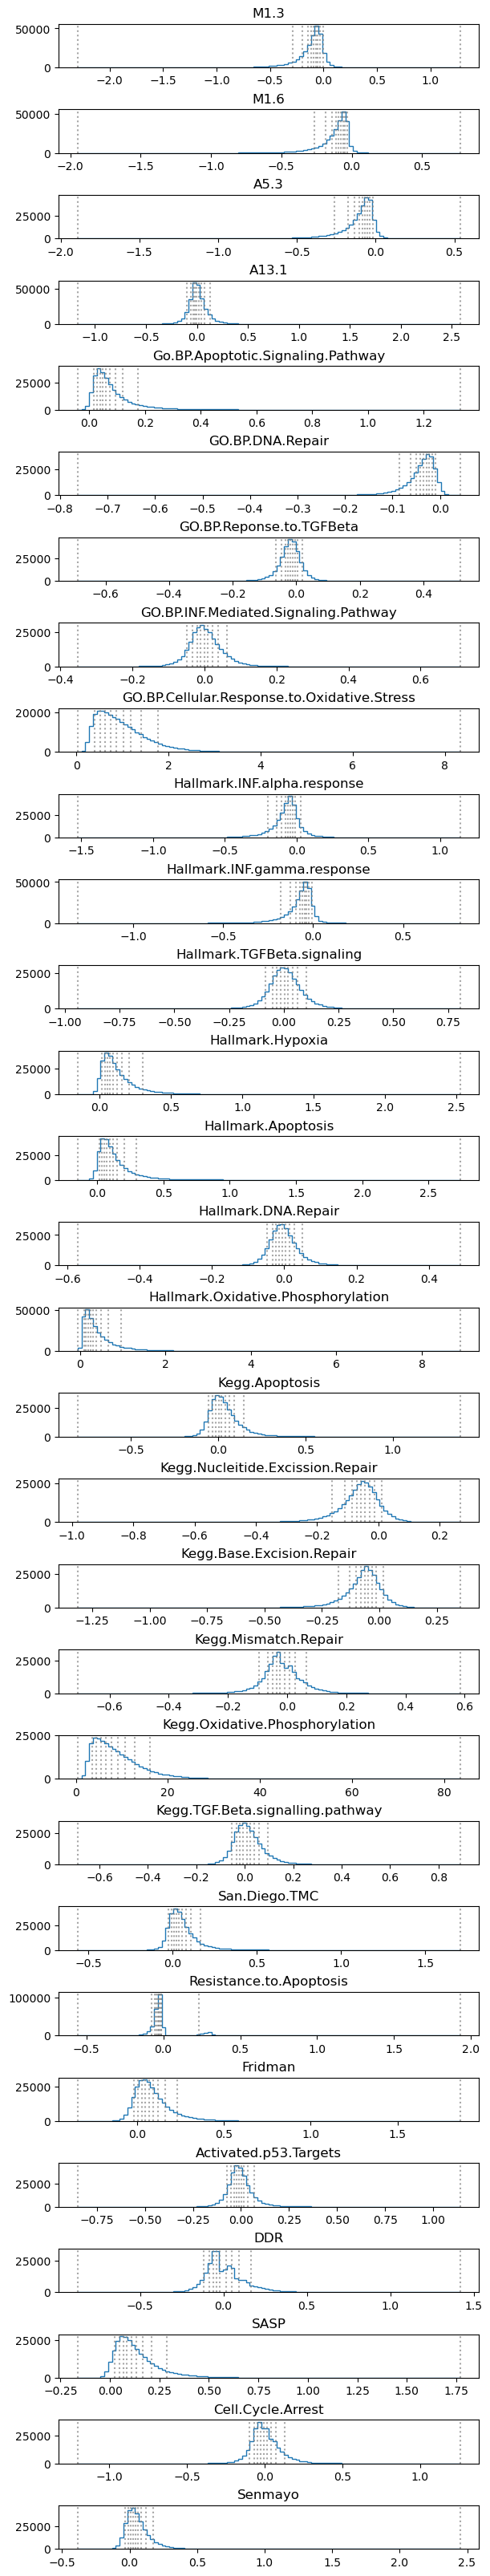

In [8]:
fig, ax = plt.subplots(len(sen_flavors), figsize=(6,32), constrained_layout=True)
for i, col in enumerate(sen_flavors):
    ax[i].hist(df[col], histtype='step', bins=100)
    ax[i].set_title(col)

    # Plot location of deciles
    _, bins = pd.qcut(df[col], 10, retbins=True)
    for b in bins:
        ax[i].axvline(b, linestyle='dotted', color='grey', alpha=0.7)

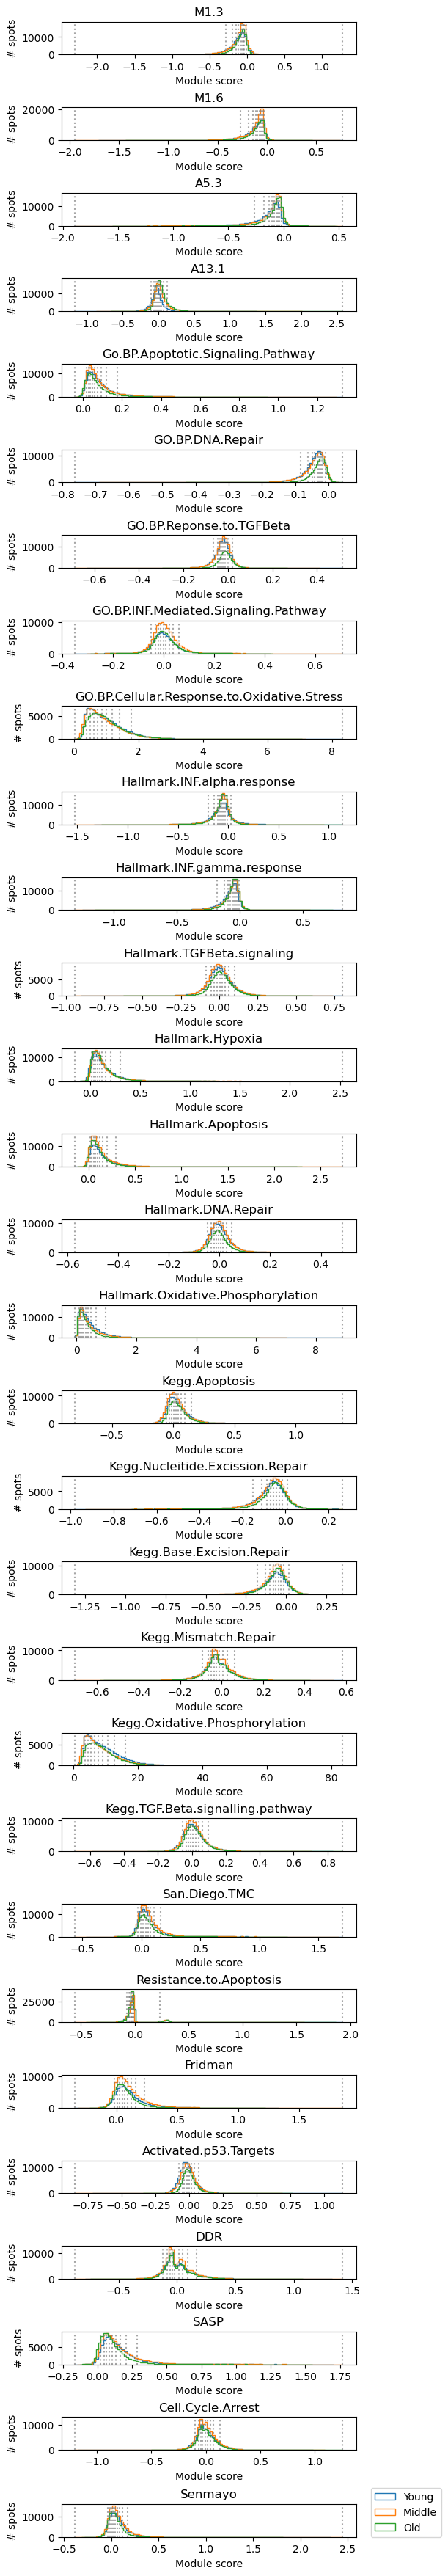

In [10]:
# as above, but separated by age group
fig, ax = plt.subplots(len(sen_flavors), figsize=(6,35), constrained_layout=True)
for i, col in enumerate(sen_flavors):
    for age in ['Young', 'Middle', 'Old']:
        inds_age = adata.obs['Level 1']==age
        ax[i].hist(df.loc[inds_age, col], histtype='step', bins=100, label=age)
    ax[i].set_title(col)

    # Plot location of deciles
    _, bins = pd.qcut(df[col], 10, retbins=True)
    for b in bins:
        ax[i].axvline(b, linestyle='dotted', color='grey', alpha=0.7)
        ax[i].set_xlabel('Module score')
        ax[i].set_ylabel('# spots')
plt.legend(loc=(1.05,0))
plt.savefig('plots/senmodules_deciles.png', dpi=300)

Generate discrete labels for each flavor of senescence by quantile-cutting the scores (deciles)

In [11]:
n_quant=10
for sf in sen_flavors:
    lbl_names = ['d%d' % i for i in range(1,n_quant+1)]
    d10_lbls = pd.qcut(df[sf], q=n_quant, labels=lbl_names)
    adata.obs[sf] = d10_lbls

Perform spatial neighborhood enrichment testing for each flavor of senescence using decile-discretized module scores

In [12]:
def enrichment_by_condition(adata, obs_lbl, condition_lbl, library_key=None, 
                            condition_order=None, vmin=None, vmax=None):
    if condition_order is None:
        conditions = adata.obs[condition_lbl].cat.categories
    else:
        conditions = condition_order
    labels = adata.obs[obs_lbl].cat.categories
    
    h_fig = 0.25 * len(labels)
    fig, ax = plt.subplots(1, len(conditions), 
                           figsize=(len(conditions)*h_fig, h_fig),
                           constrained_layout=True)

    # Find zmat per conditions, and store vmin/vmax across them
    zmat_conds = {}
    infer_vmax, infer_vmin = False, False
    if vmin is None:
        vmin = np.inf
        infer_vmin = True
    if vmax is None:
        vmax = -np.inf
        infer_vmax = True
    for i, cond in enumerate(conditions):
        adata_cond = adata[adata.obs[condition_lbl] == cond].copy()
        sq.gr.nhood_enrichment(adata_cond, 
                               cluster_key=obs_lbl, 
                               library_key=library_key,
                               show_progress_bar=False
                              )

        zmat = adata_cond.uns['%s_nhood_enrichment' % obs_lbl]['zscore']
        zmat_conds[cond] = zmat
        if infer_vmin and zmat.min() < vmin:
            vmin = zmat.min()
        if infer_vmax and zmat.max() > vmax:
            vmax = zmat.max()

    # Plot zmat per condition
    for i, cond in enumerate(conditions):
        show_cbar = i==(len(conditions)-1)

        sns.heatmap(zmat_conds[cond], ax=ax[i],
                    cmap='bwr', center=0, vmin=vmin, vmax=vmax, 
                    cbar=show_cbar, cbar_kws={'label':'Enrichment'},
                    xticklabels=labels, yticklabels=(labels if i==0 else False))
        ax[i].set_title(cond)
    plt.suptitle(obs_lbl)
    
    return ax

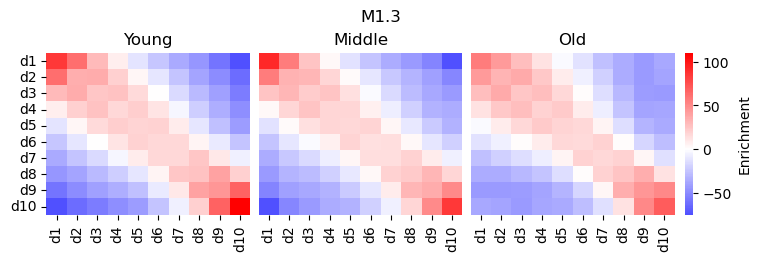

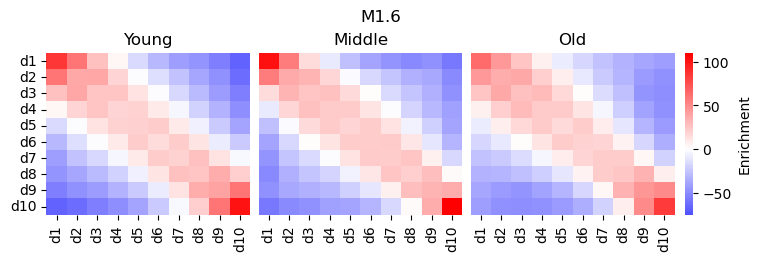

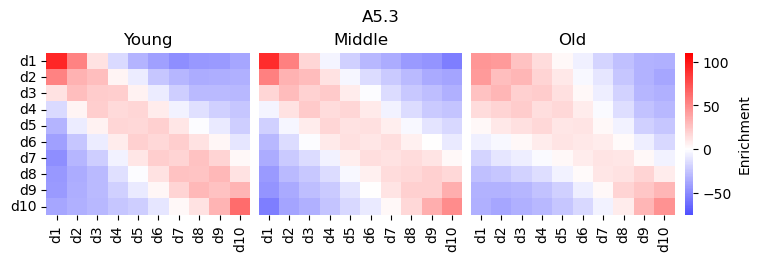

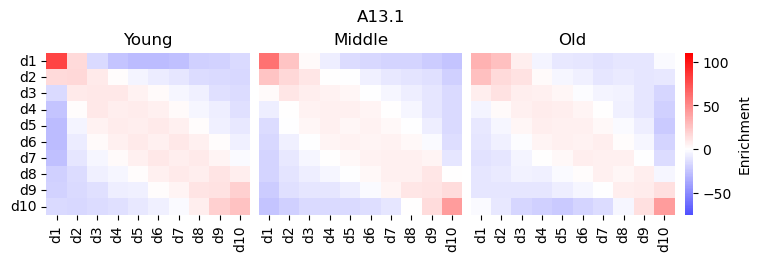

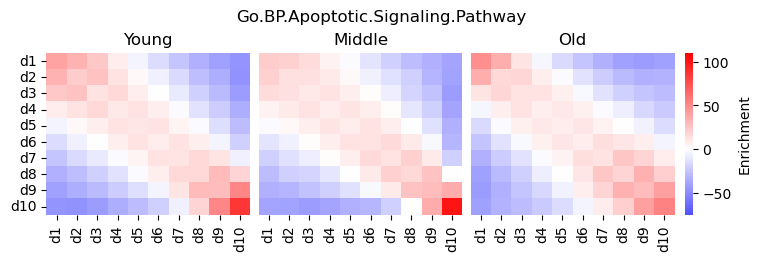

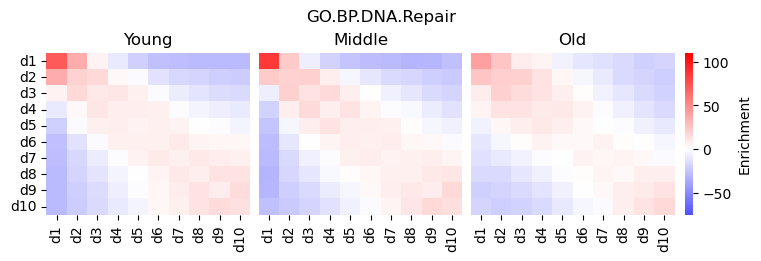

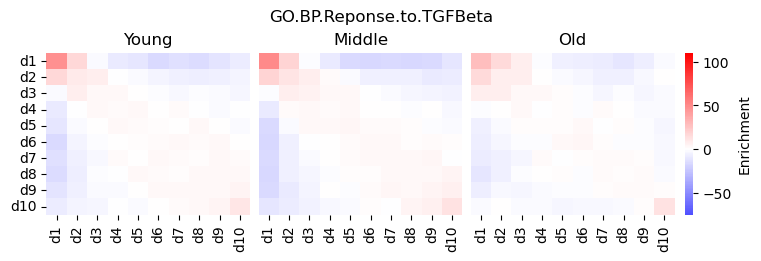

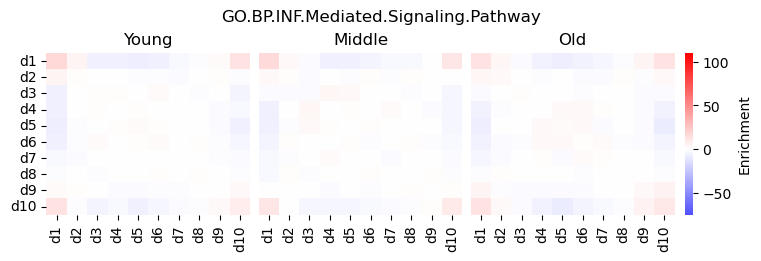

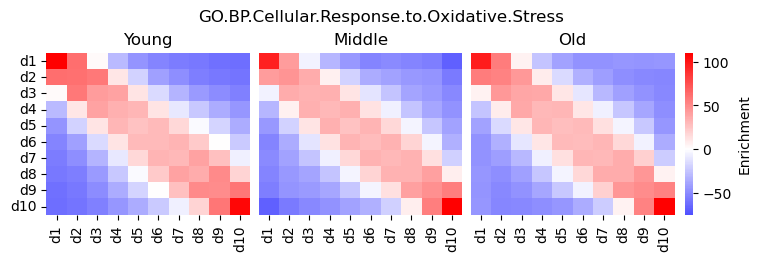

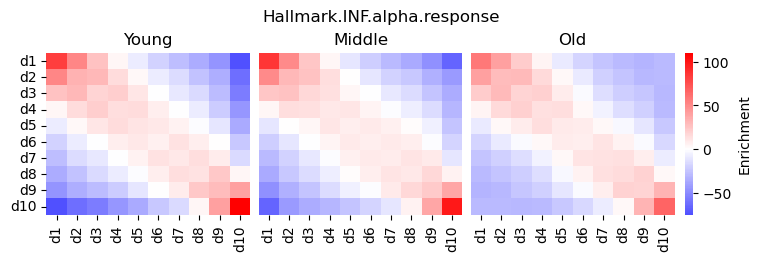

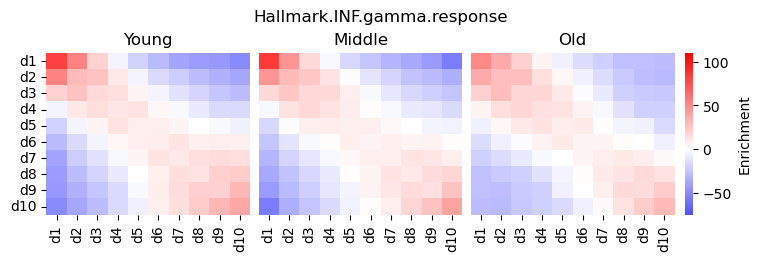

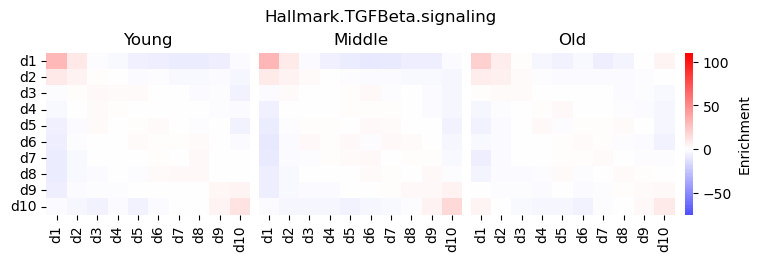

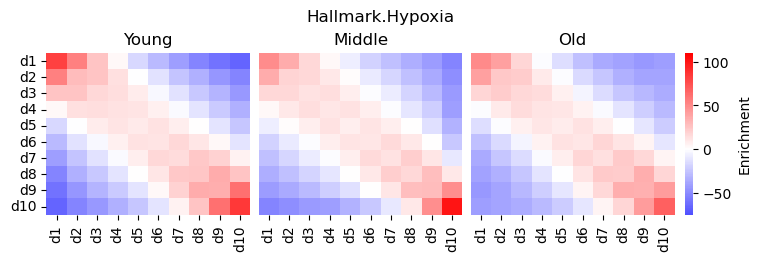

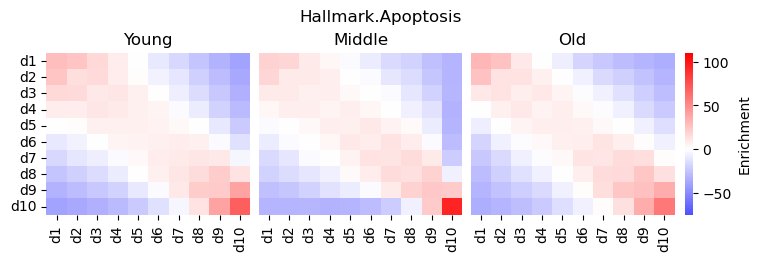

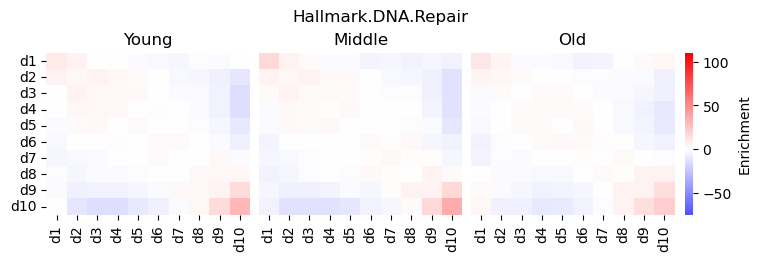

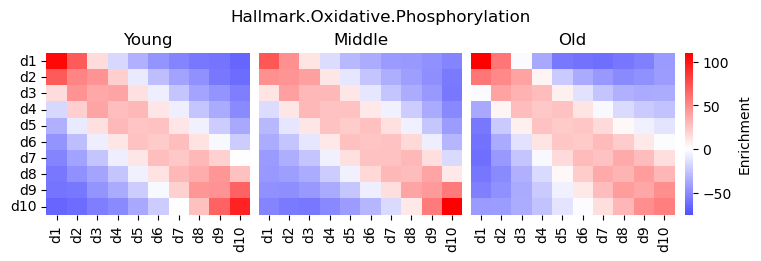

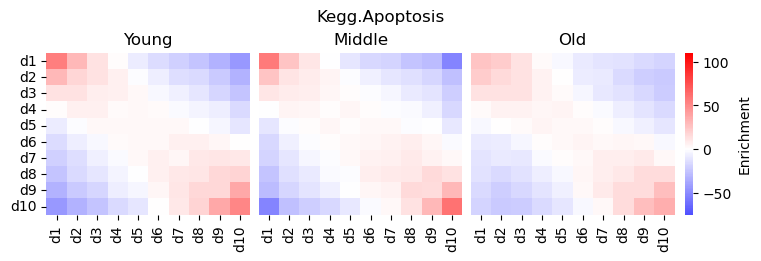

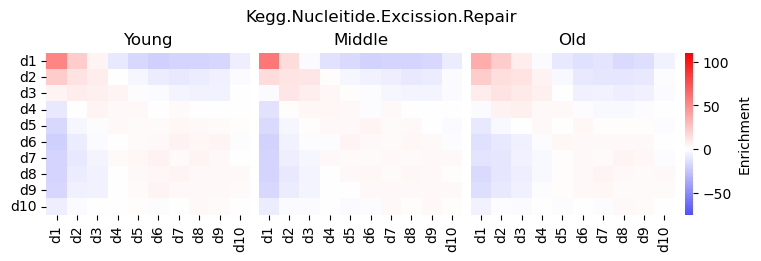

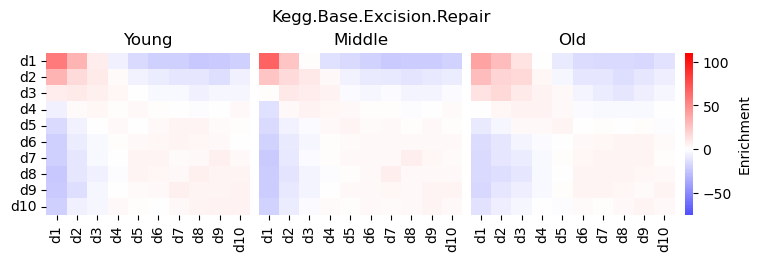

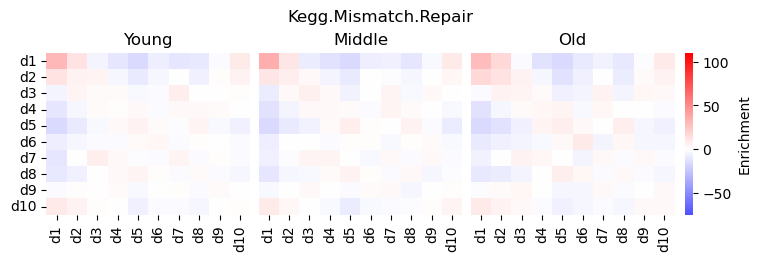

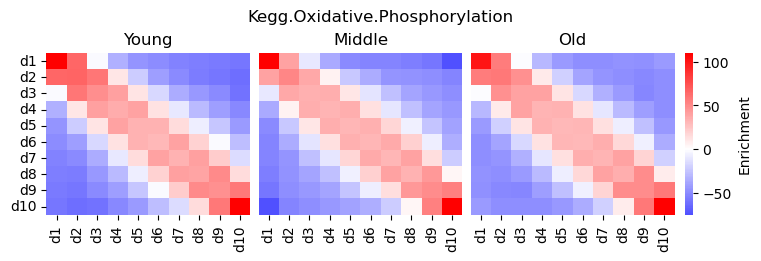

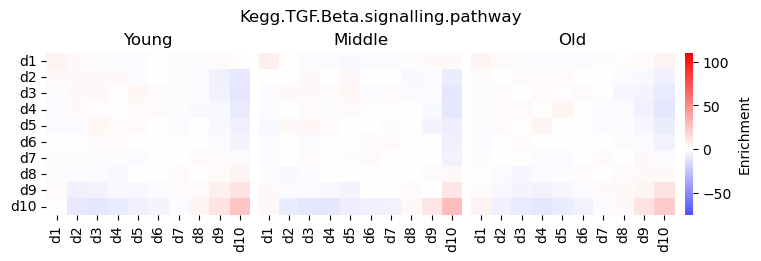

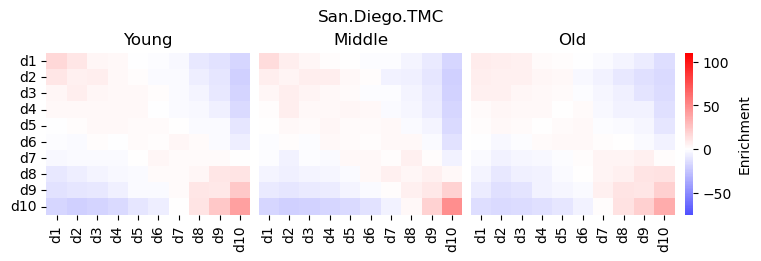

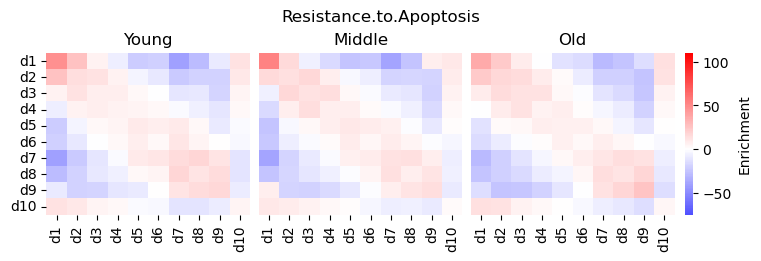

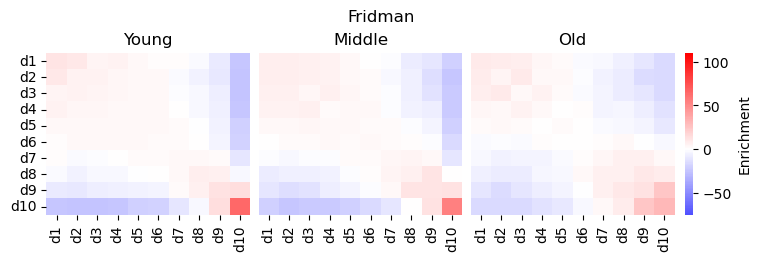

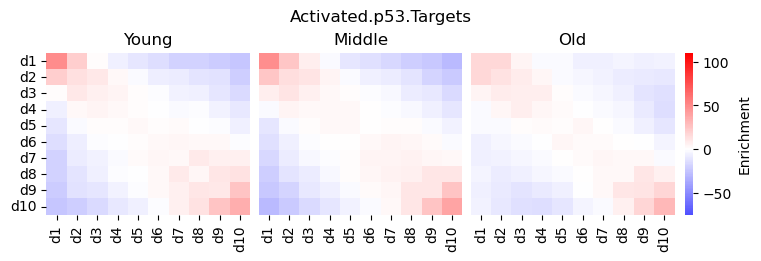

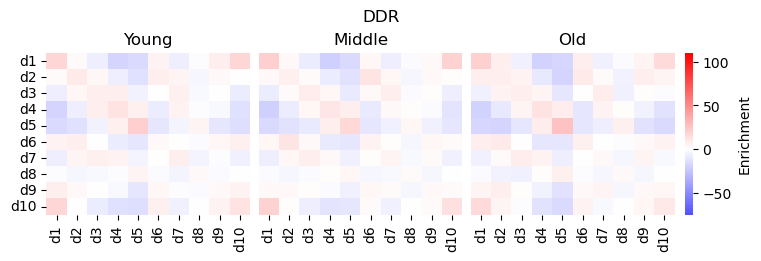

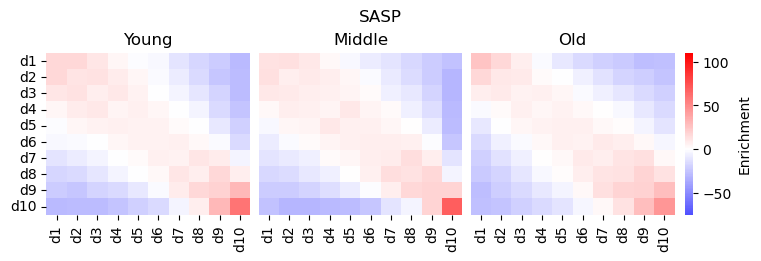

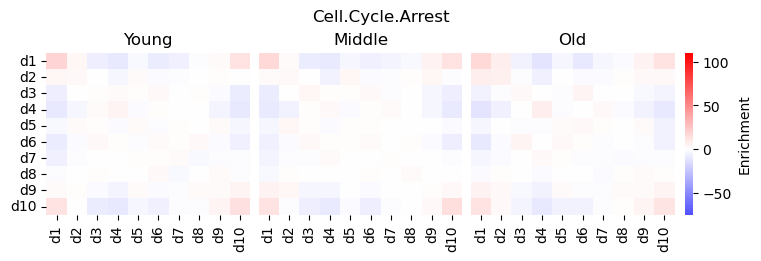

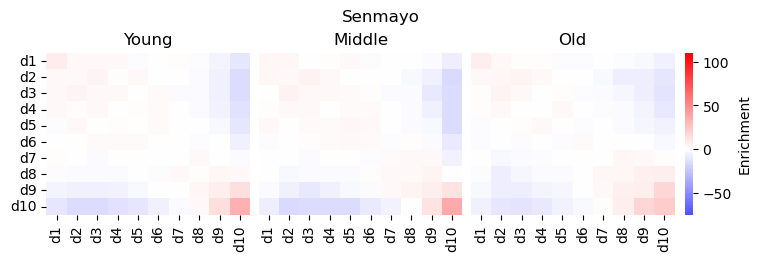

In [15]:
for sf in sen_flavors:
    enrichment_by_condition(adata, sf, 'Level 1', 'visarray', 
                            condition_order=['Young', 'Middle', 'Old'],
                           vmin=-75, vmax=110)
    plt.savefig('plots/self_enrichment/%s_nhood_enrich.png' % plot_friendly_name(sf), dpi=300)
    plt.show()
    plt.close()

As above, but calculate p-values per interaction term describing significance of enrichment change relative to "Young"

In [16]:
def to_star(p):
	if p < 1e-4:
		return '****'
	elif p < 1e-3:
		return '***'
	elif p < 1e-2:
		return '**'
	elif p < 0.05:
		return '*'
	else:
		return ''

def enrichment_change_by_condition(adata, obs_lbl, condition_lbl, comps, library_key, vmin=None, vmax=None):
    labels = adata.obs[obs_lbl].cat.categories
    enr_by_cond = {}

    # Calculate enrichment matrix per-batch, separated by sample condition
    for cond in adata.obs[condition_lbl].cat.categories:
        if cond not in enr_by_cond.keys():
            enr_by_cond[cond] = []
        adata_cond = adata[adata.obs[condition_lbl] == cond]
        
        for arr in adata_cond.obs[library_key].unique():
            adata_arr = adata_cond[adata_cond.obs[library_key]==arr]
            zmat,cmat = sq.gr.nhood_enrichment(adata_arr, 
                                                cluster_key=obs_lbl, 
                                                show_progress_bar=False,
                                                copy=True)
            # in case all categories are not represented:
            zmat_all = pd.DataFrame(np.zeros((len(labels), len(labels))), index=labels, columns=labels)
            for i, l1 in enumerate(adata_arr.obs[obs_lbl].cat.categories):
                for j, l2 in enumerate(adata_arr.obs[obs_lbl].cat.categories):
                    zmat_all.loc[l1,l2] = zmat[i,j]
            
            enr_by_cond[cond].append(zmat_all.values)
    
    for cond in enr_by_cond.keys():
        enr_by_cond[cond] = np.array(enr_by_cond[cond])

    # Generate a heatmap for each comparison, showing Delta(enrichment) in color and significance in * notation
    h_fig = 0.25 * len(labels)
    fig, ax = plt.subplots(1, len(comps), figsize=(len(comps)*h_fig, h_fig),
                           constrained_layout=True)
    
    for i, (c1, c2) in enumerate(comps):
        e1 = enr_by_cond[c1]
        e2 = enr_by_cond[c2]
    
        dmat = e1.mean(axis=0)-e2.mean(axis=0)
        pmat = np.zeros_like(dmat)
    
        # Calculate pval across conditions for all pairs of labels
        for j in range(e1.shape[0]):
            for k in range(j, e1.shape[1]):
                _, pval = ranksums(e1[:,j,k], e2[:,j,k])
                pmat[j,k] = pval
                pmat[k,j] = pval
    
        # Perform FDR correction
        mask = np.tril(np.ones_like(pmat, dtype=bool))
        pvals_flat = pmat.flatten()
        _, pvals_adj = fdrcorrection(pvals_flat[np.ravel(mask)], is_sorted=False)
        pvals_flat[np.ravel(mask)] = pvals_adj
        pmat_adj = np.reshape(pvals_flat, pmat.shape)

        if vmin is not None and vmax is not None:
            show_cbar = i==(len(comps)-1)
        else:
            show_cbar = True
        
        sns.heatmap(dmat, cmap='seismic', center=0, vmin=vmin, vmax=vmax,
                    annot=pd.DataFrame(pmat_adj).map(to_star), fmt="",
                    mask=np.logical_not(mask),
                    cbar=show_cbar,
                    xticklabels=labels, yticklabels=(labels if i==0 else False),
                    cbar_kws={'label':r'$\Delta$Enrichment'}, ax=ax[i])
        ax[i].set_title('%s (vs. %s)' % (c1, c2))
    plt.suptitle(obs_lbl)
    
    return ax

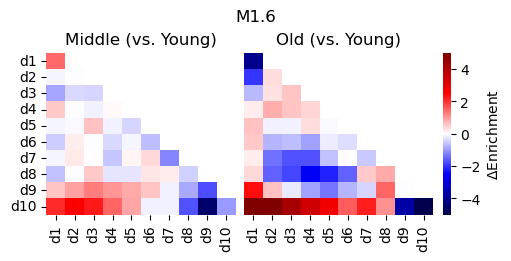

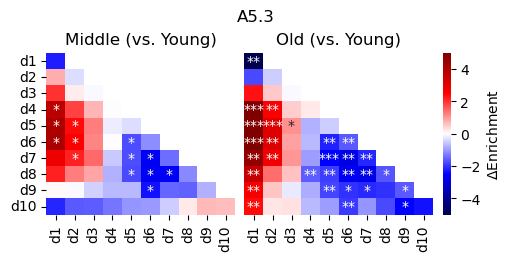

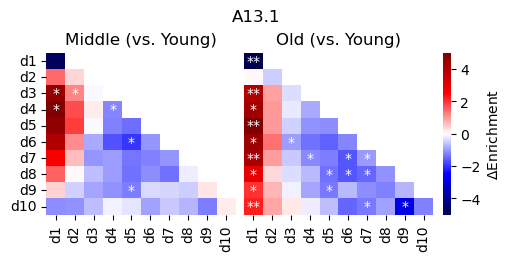

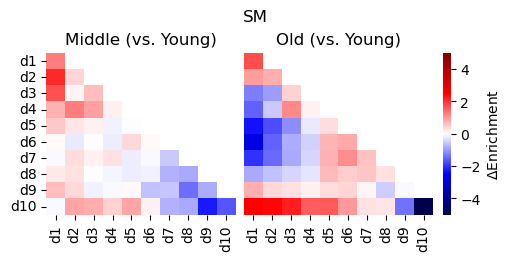

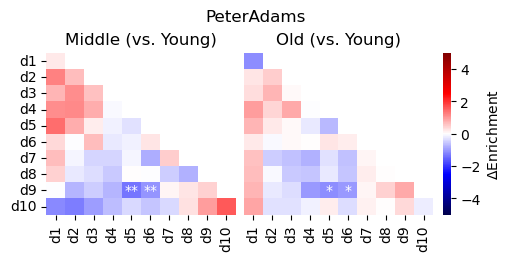

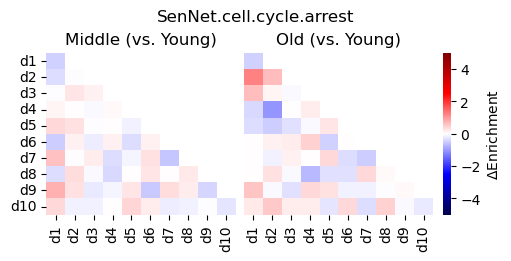

/Users/aidandaly/miniforge3/lib/python3.10/site-packages/squidpy/gr/_nhood.py:194: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


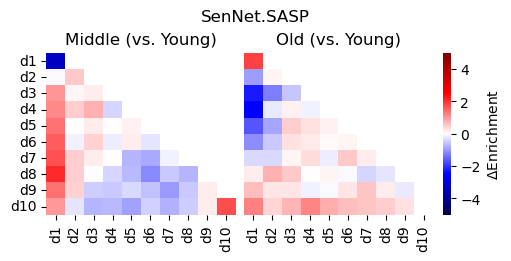

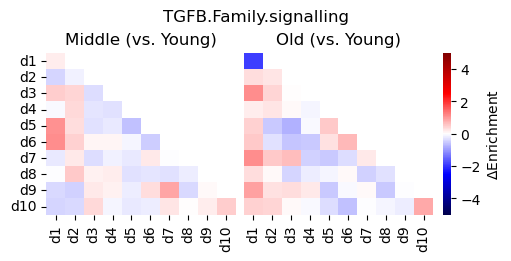

/Users/aidandaly/miniforge3/lib/python3.10/site-packages/squidpy/gr/_nhood.py:194: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


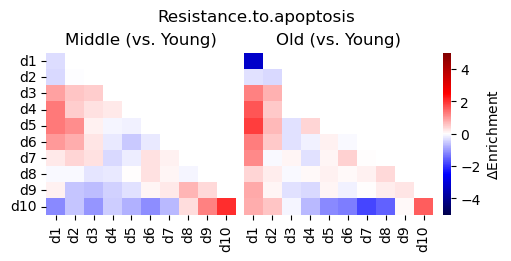

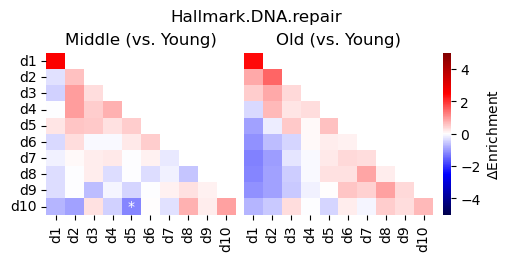

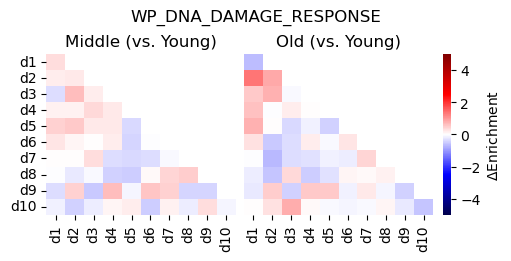

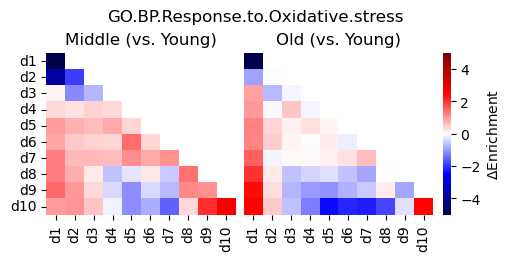

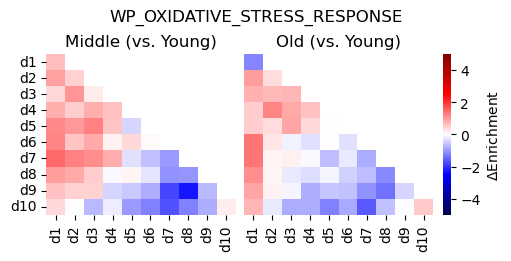

In [17]:
for sf in sen_flavors:
    enrichment_change_by_condition(adata, sf, 'Level 1', [('Middle', 'Young'), ('Old', 'Young')], 'visarray', 
                                   vmin=-5, vmax=5)
    plt.savefig('plots/self_enrichment/%s_nhood_enrich_delta.png' % sf, dpi=300)
    plt.show()

For each senescence module, characterize the spots of a given decile in terms of:
1. Frequency of each AAR
2. Average cell type composition
3. Any genes (outside of module) DE with neighbors

AAR profile of spots by senmodule score:

<Axes: title={'center': 'Senmayo (d10)'}, xlabel='# spots'>

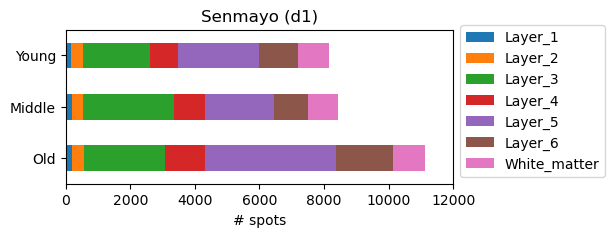

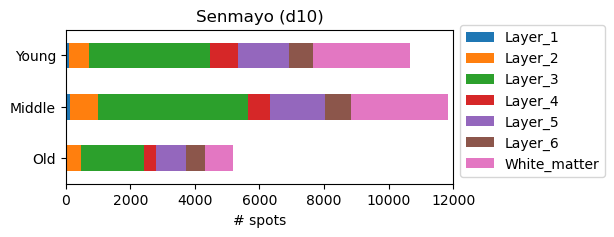

In [15]:
# For a given senescence module and expression level, plot number of spots in each AAR (per age group)
def aar_by_label(adata, obs_col, lbl, xmax=None):
    incl_aars = adata.obs.region.cat.categories

    value_counts = {}
    for age in ['Young', 'Middle', 'Old']:
        adata_age = adata[adata.obs['Level 1']==age]
        adata_sub = adata_age[adata_age.obs[obs_col]==lbl]
        vc = adata_sub.obs.region.value_counts()[incl_aars]
        value_counts[age] = vc

    value_counts = pd.DataFrame(value_counts)
    ax = value_counts.T.plot.barh(stacked=True, figsize=(5,2))
    ax.invert_yaxis()
    
    plt.legend(bbox_to_anchor=(1,0), loc='lower left')
    plt.xlabel('# spots')
    plt.title('%s (%s)' % (obs_col, lbl))

    if xmax is not None:
        ax.set_xlim(0, xmax)
    return ax

aar_by_label(adata, 'Senmayo', 'd1', xmax=12000)
aar_by_label(adata, 'Senmayo', 'd10', xmax=12000)

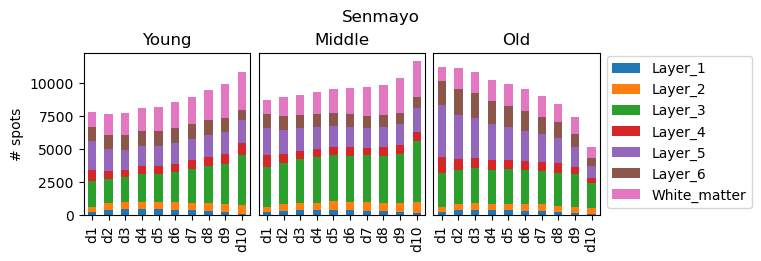

In [16]:
# For a given senescence module, plot number of spots of each score that fall into each AAR.
# Separate subplot per age group -- meant to parallel the spatial organization plots
def senmodule_location_by_activity(adata, obs_lbl, condition_lbl, condition_order=None):
    if condition_order is None:
        conditions = adata.obs[condition_lbl].cat.categories
    else:
        conditions = condition_order
    labels = adata.obs[obs_lbl].cat.categories
    
    h_fig = 0.25 * len(labels)
    fig, ax = plt.subplots(1, len(conditions), 
                           figsize=(len(conditions)*h_fig, h_fig),
                           constrained_layout=True)

    for i, cond in enumerate(conditions):
        adata_cond = adata[adata.obs[condition_lbl] == cond]
        value_counts = {}
        for lvl in adata.obs[obs_lbl].cat.categories:
            vc = adata_cond.obs.region[adata_cond.obs[obs_lbl]==lvl].value_counts()
            value_counts[lvl] = vc
        value_counts = pd.DataFrame(value_counts)

        value_counts.T.plot.bar(stacked=True, ax=ax[i])
        ax[i].set_title(cond)
        
    # Ensure same ylims for all subplots; legend on last one only
    ymax = 0
    for i in range(len(ax)):
        ylim = ax[i].get_ylim()
        if ylim[1] > ymax:
            ymax = ylim[1]
    for i in range(len(ax)):
        ax[i].set_ylim(0, ymax)
        if i > 0:
            ax[i].set_yticks([])
        if i < len(ax)-1:
            ax[i].get_legend().remove()

    ax[0].set_ylabel('# spots')

    plt.legend(bbox_to_anchor=(1,0), loc='lower left')
    plt.suptitle(obs_lbl)
    return ax

ax = senmodule_location_by_activity(adata, 'Senmayo', 'Level 1', condition_order=['Young', 'Middle', 'Old'])

In [17]:
for sf in sen_flavors:
    ax = senmodule_location_by_activity(adata, sf, 'Level 1', condition_order=['Young', 'Middle', 'Old'])
    plt.savefig(os.path.join('plots', 'senmodule_locations', '%s_aars.png' % plot_friendly_name(sf)), dpi=300)
    plt.close()

Cell composition profile of spots by senmodule score:

In [18]:
# Import results of deconvolution
deconv_file = os.path.join('..', 'deconvolution', 'output_cell2location', 'mapped_clusters_comp_cell2location.tsv')
deconv = pd.read_csv(deconv_file, header=0, index_col=0, sep='\t')

spots_shared = adata.obs.index.intersection(deconv.index)
adata = adata[spots_shared].copy()
adata.obsm['cell2location'] = deconv.loc[spots_shared]

In [19]:
# Combine subclasses into broad classes
broadclass = np.unique([c.split('.')[0] for c in adata.obsm['cell2location']])
deconv_broad = {}
for ct in broadclass:
    subclasses = [c for c in adata.obsm['cell2location'].columns if c.startswith(ct)]
    deconv_broad[ct] = adata.obsm['cell2location'][subclasses].sum(axis=1)
adata.obsm['cell2location_broad'] = pd.DataFrame(deconv_broad, index=spots_shared)

In [20]:
# Normalize compositions to sum to 1.0
for deconv in ['cell2location', 'cell2location_broad']:
    adata.obsm[deconv] = adata.obsm[deconv].div(adata.obsm[deconv].sum(axis=1), axis=0)

In [21]:
# Custom color cycle for (broad) cell types:
#            Ast             End          Exc          Inh         Mic     OPC          Oli     Peri
cell_color=['lightskyblue', 'goldenrod', 'firebrick', 'darkblue', 'pink', 'lightgrey', 'grey', 'saddlebrown']

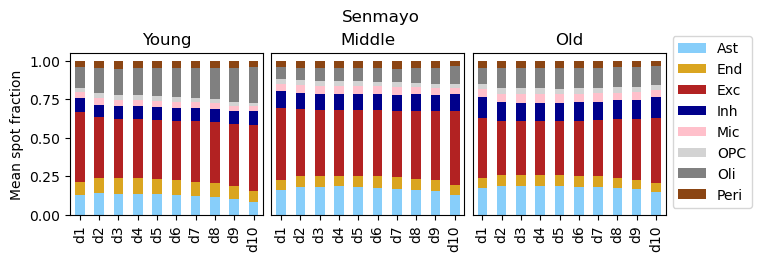

In [22]:
def senmodule_cellcomp_by_activity(adata, obs_col, condition_col, deconv, condition_order=None):
    if condition_order is None:
        conditions = adata.obs[condition_col].cat.categories
    else:
        conditions = condition_order
    labels = adata.obs[obs_col].cat.categories
    
    h_fig = 0.25 * len(labels)
    fig, ax = plt.subplots(1, len(conditions), 
                           figsize=(len(conditions)*h_fig, h_fig),
                           constrained_layout=True)

    for i, cond in enumerate(conditions):
        adata_cond = adata[adata.obs[condition_col] == cond]
        spot_comps = {}
        for lvl in adata.obs[obs_col].cat.categories:
            comp = adata_cond[adata_cond.obs[obs_col]==lvl].obsm[deconv].mean(axis=0)
            spot_comps[lvl] = comp
        spot_comps = pd.DataFrame(spot_comps)

        spot_comps.T.plot.bar(stacked=True, ax=ax[i], color=cell_color)
        ax[i].set_title(cond)
        
    # Ensure same ylims for all subplots; legend on last one only
    ymax = 0
    for i in range(len(ax)):
        ylim = ax[i].get_ylim()
        if ylim[1] > ymax:
            ymax = ylim[1]
    for i in range(len(ax)):
        ax[i].set_ylim(0, ymax)
        if i > 0:
            ax[i].set_yticks([])
        if i < len(ax)-1:
            ax[i].get_legend().remove()

    ax[0].set_ylabel('Mean spot fraction')

    plt.legend(bbox_to_anchor=(1,0), loc='lower left')
    plt.suptitle(obs_col)
    return ax

ax = senmodule_cellcomp_by_activity(adata, 'Senmayo', 'Level 1', 'cell2location_broad', condition_order=['Young', 'Middle', 'Old'])

/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_21600/3572558497.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, len(conditions),


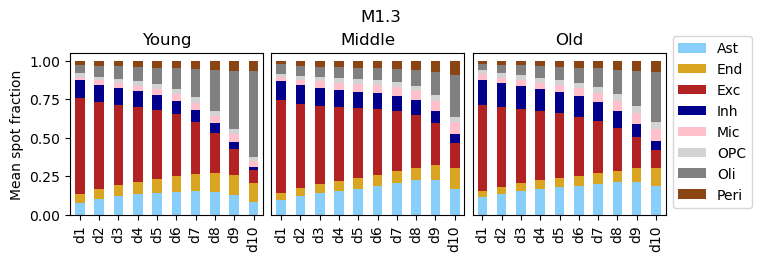

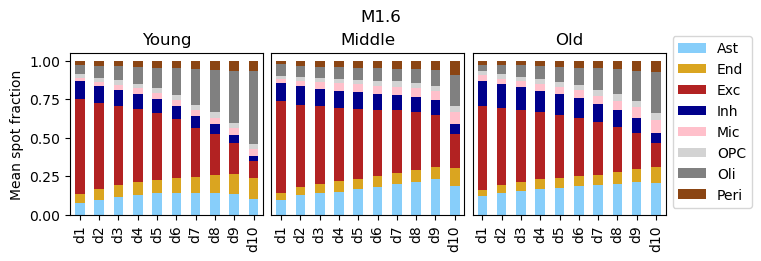

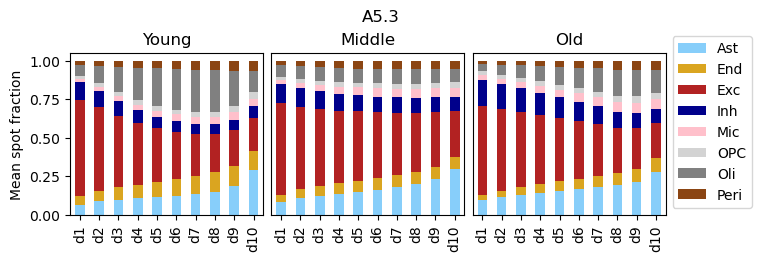

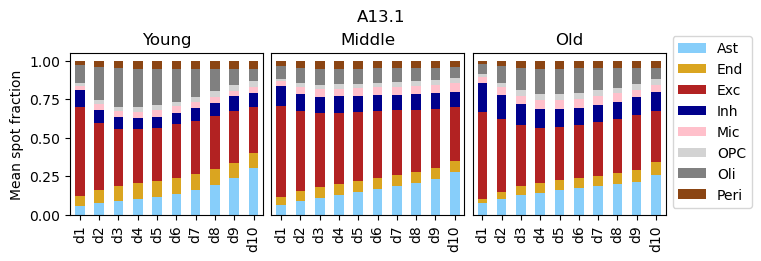

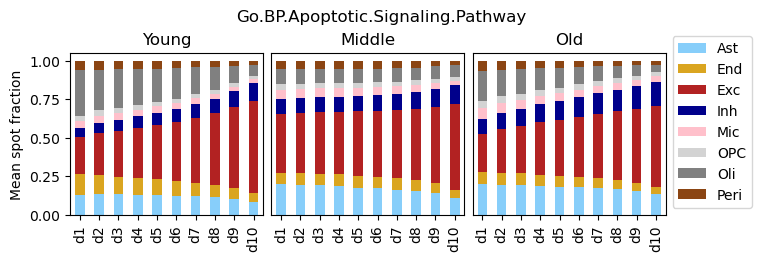

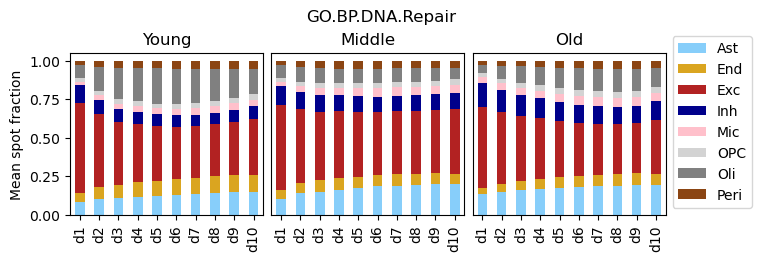

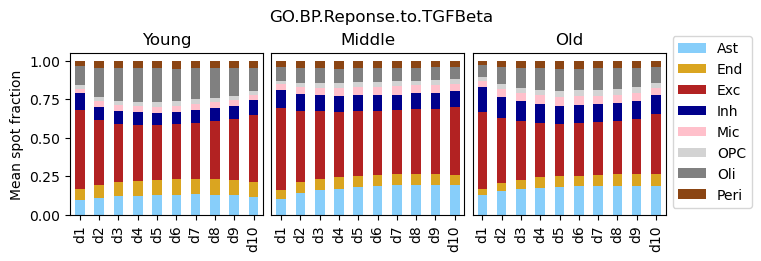

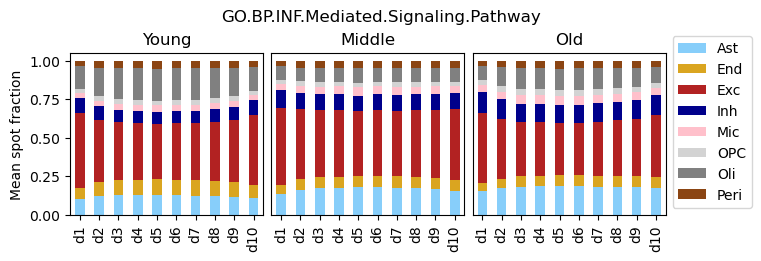

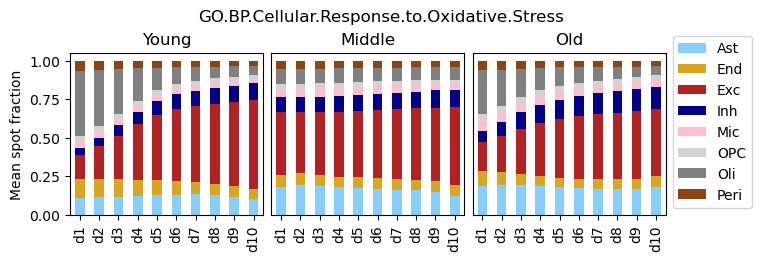

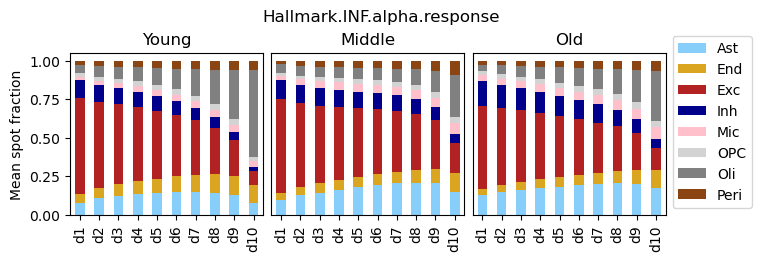

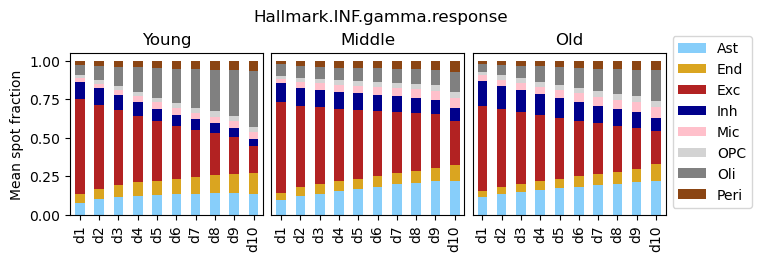

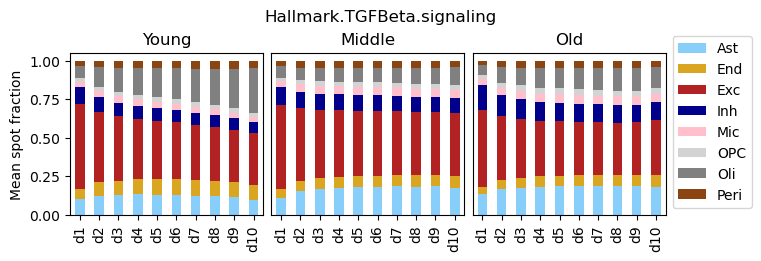

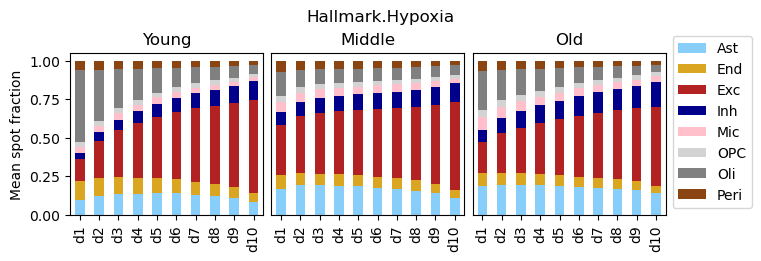

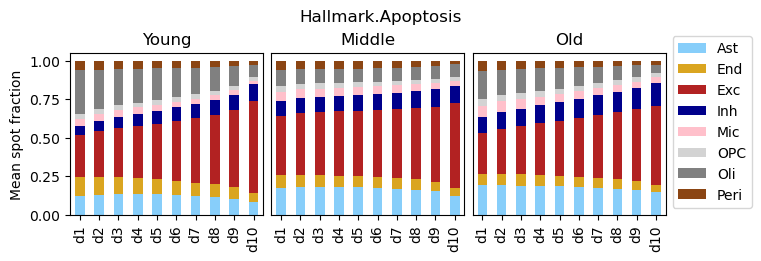

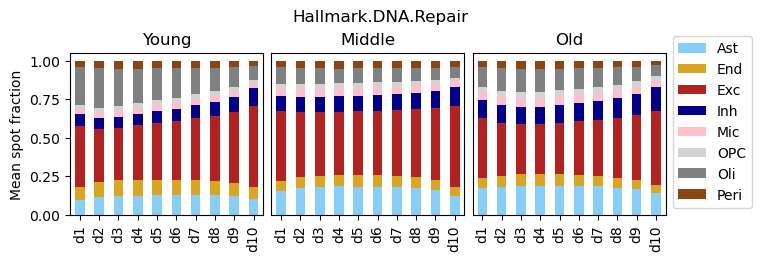

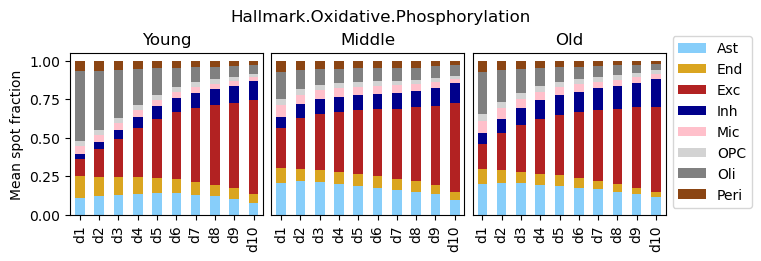

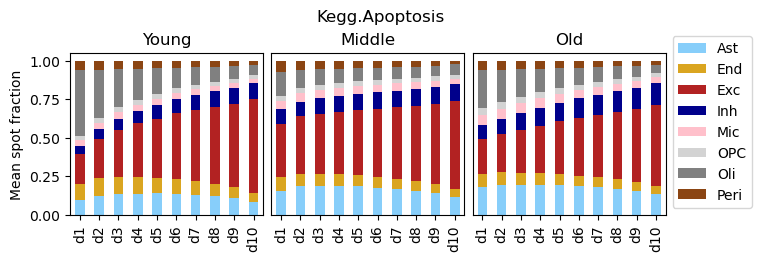

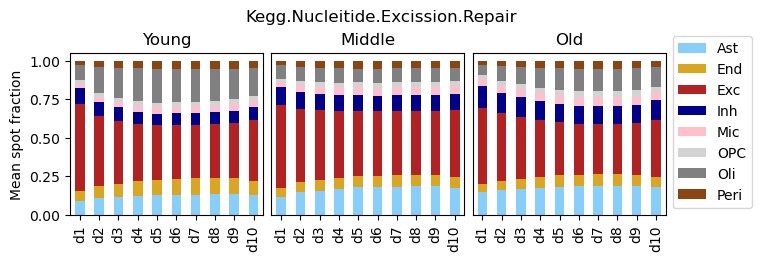

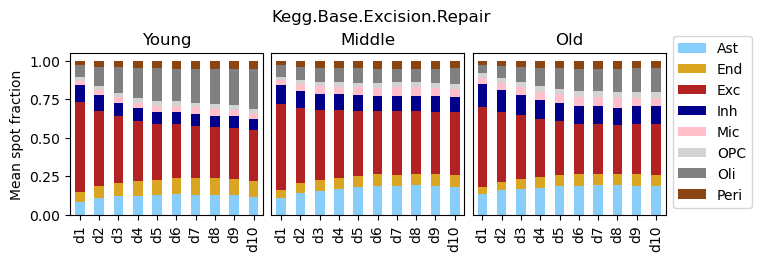

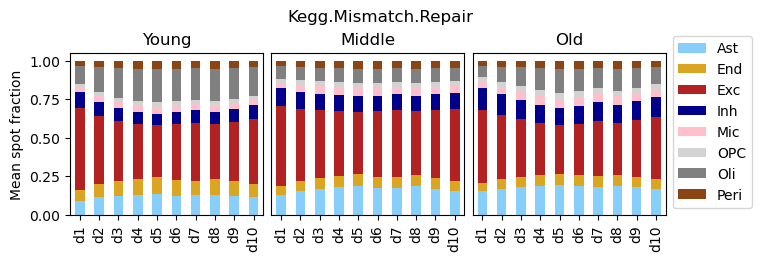

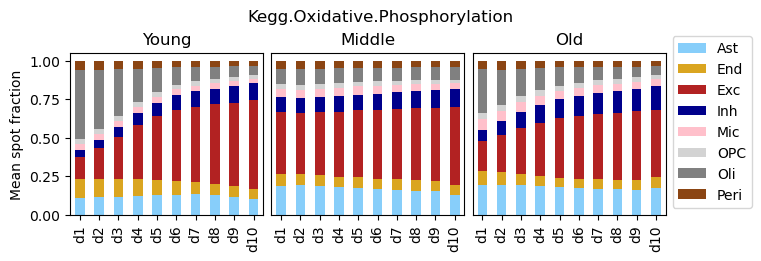

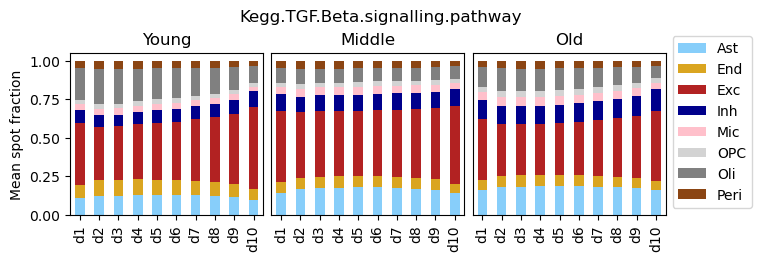

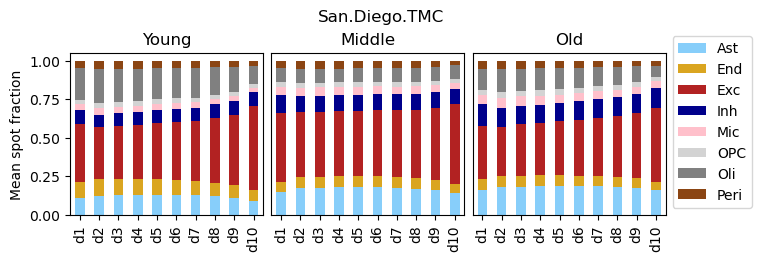

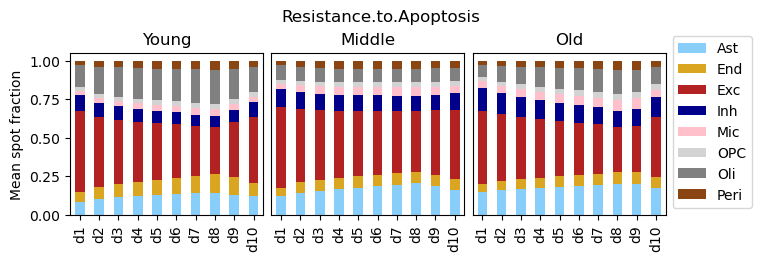

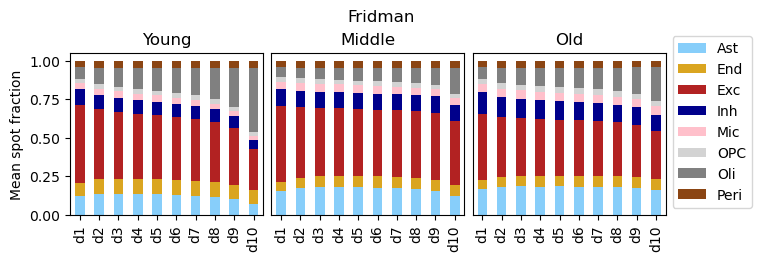

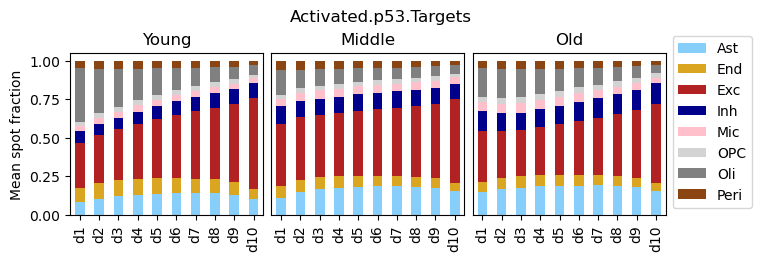

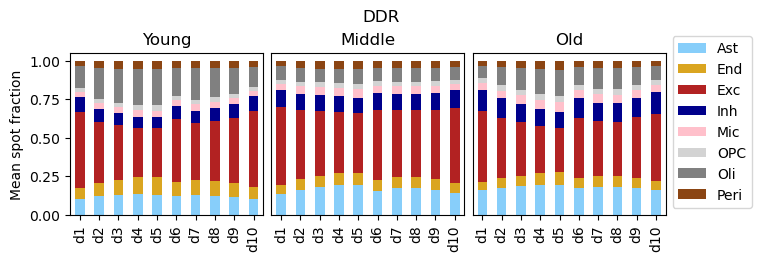

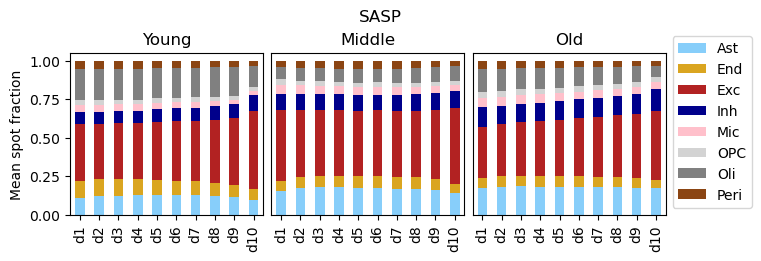

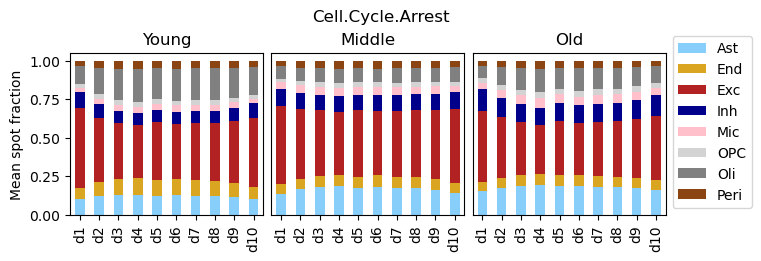

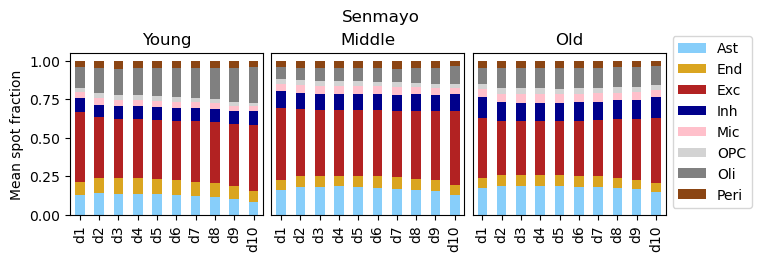

In [23]:
for sf in sen_flavors:
    ax = senmodule_cellcomp_by_activity(adata, sf, 'Level 1', 'cell2location_broad', condition_order=['Young', 'Middle', 'Old'])
    plt.savefig(os.path.join('plots', 'senmodule_compositions', '%s_cellcomp.png' % plot_friendly_name(sf)), dpi=300)

Find genes DE between spots of a given senescence score and their neighbors

In [25]:
# Read in list of member genes per module so we can exclude from DE analysis
df_member = pd.read_excel('senescence_module_genes.xlsx', sheet_name='Version 2')

19655 spots with Submodule 1.3 (MHC 1 presenting endothelial cells)=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


41824 neighbors with Submodule 1.3 (MHC 1 presenting endothelial cells)!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
116 module member genes excluded


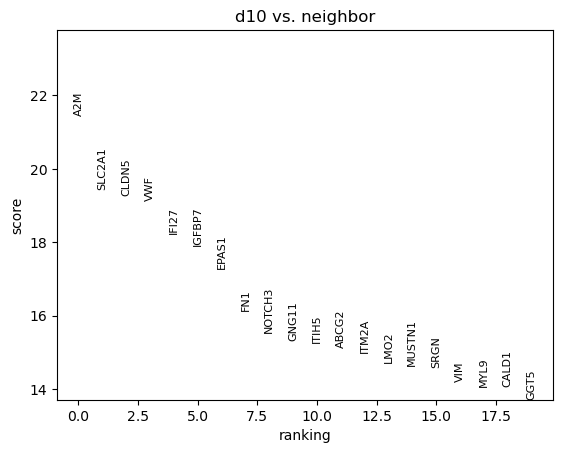

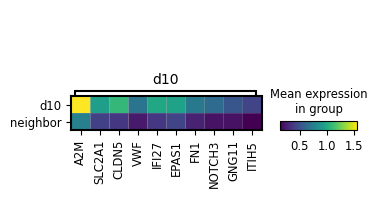

In [37]:
def senmodule_degenes_neighbors(adata, module_col, lvl, batch_col=None, save=None, member_genes=None):
    # All spots expressing module at given level
    adata_in = adata[adata.obs[module_col]==lvl].copy()
    print(len(adata_in), 'spots with %s=%s' % (module_col, lvl))

    # All spots neighboring those of given level
    neighbor_pts = []
    pts1, pts2 = adata.obsp['spatial_connectivities'].nonzero()
    for p1, p2 in zip(adata.obs_names[pts1], adata.obs_names[pts2]):
        if adata.obs.loc[p1, module_col]==lvl and adata.obs.loc[p2, module_col]!=lvl:
            neighbor_pts.append(p2)
    adata_out = adata[neighbor_pts].copy()
    print(len(adata_out), 'neighbors with %s!=%s' % (module_col, lvl))

    # group all neighbors into one class
    adata_out.obs[module_col] = 'neighbor'

    # Ensure no spots overlap
    assert len(adata_in.obs.index.intersection(adata_out.obs.index)) == 0

    adata_merge = ad.concat([adata_in, adata_out], merge='same')
    adata_merge.obs_names_make_unique()

    # Pseudo-bulk within arrays
    if batch_col is None:
        adata_pb = adata_merge
    else:
        batch_list, lvl_list, mu_list = [],[],[]
        for (batch, l), pb in adata_merge.obs.groupby([batch_col, module_col], observed=True):
            mu = np.array(adata_merge[pb.index].X.mean(axis=0)).squeeze()
            
            batch_list.append(batch)
            lvl_list.append(l)
            mu_list.append(mu)
        
        adata_pb = ad.AnnData(X=np.array(mu_list), var=adata_merge.var,
                              obs=pd.DataFrame({batch_col:batch_list, module_col:lvl_list}))

    print(adata_pb.obs[module_col].unique())

    # Depth-normalize and log-transform
    sc.pp.normalize_total(adata_pb, target_sum=1e4)
    sc.pp.log1p(adata_pb)

    if save is not None:
        save_scores = save + '_scoreplot.png'
        save_heat = save + '_heatmap.png'
    else:
        save_scores, save_heat = None, None

    mask = None
    if member_genes is not None:
        mask = np.array([adata.var.loc[x, 'gene_name'] not in member_genes for x in adata.var_names])
        print(np.sum(np.logical_not(mask)), 'module member genes excluded')

    sc.tl.rank_genes_groups(adata_pb, groupby=module_col, reference='neighbor', mask_var=mask)
    sc.pl.rank_genes_groups(adata_pb, groups=[lvl], n_genes=20, gene_symbols='gene_name', show=False)
    plt.savefig(save_scores)

    df_deg = sc.get.rank_genes_groups_df(adata_pb, [lvl], pval_cutoff=0.05, log2fc_min=1.5, gene_symbols='gene_name')

    if len(df_deg) > 0:
        sc.tl.rank_genes_groups(adata_pb, groupby=module_col, reference='neighbor', mask_var=mask)
        sc.pl.rank_genes_groups_matrixplot(adata_pb, groups=None, n_genes=10, 
                                           min_logfoldchange=1.5, gene_symbols='gene_name', show=False)
        plt.subplots_adjust(left=0.35, bottom=0.4)
        plt.savefig(save_heat)
    
    return df_deg
        
member_genes = df_member['Submodule 1.3 (MHC 1 presenting endothelial cells)'].dropna().values
df_deg = senmodule_degenes_neighbors(adata, 'Submodule 1.3 (MHC 1 presenting endothelial cells)', 'd10', 
                                     batch_col='visarray', save='plots/senmodule_degs/Senmayo_d10', 
                                     member_genes=member_genes)

19655 spots with Submodule 1.3 (MHC 1 presenting endothelial cells)=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


41824 neighbors with Submodule 1.3 (MHC 1 presenting endothelial cells)!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
116 module member genes excluded
23084 spots with Submodule 1.6 (sen + reactive microglia)=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


46151 neighbors with Submodule 1.6 (sen + reactive microglia)!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
298 module member genes excluded
24319 spots with Submodule 5.3 (age-enriched astro)=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


62775 neighbors with Submodule 5.3 (age-enriched astro)!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
155 module member genes excluded
24578 spots with Submodule 13.1 (age-enriched astro)=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


63636 neighbors with Submodule 13.1 (age-enriched astro)!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
98 module member genes excluded
22979 spots with Senmayo=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


68730 neighbors with Senmayo!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
59 module member genes excluded
24340 spots with SenNet cell cycle arrest (human mRNA)=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


80920 neighbors with SenNet cell cycle arrest (human mRNA)!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
8 module member genes excluded
23082 spots with SenNet SASP (human mRNA)=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


71522 neighbors with SenNet SASP (human mRNA)!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
65 module member genes excluded
20320 spots with Fridman senescence up=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


54593 neighbors with Fridman senescence up!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
62 module member genes excluded
24496 spots with Activated p53 targets (Fischer 2017)=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


76645 neighbors with Activated p53 targets (Fischer 2017)!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
90 module member genes excluded
23940 spots with Go BP Apoptotic Signaling Pathway=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


60142 neighbors with Go BP Apoptotic Signaling Pathway!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
458 module member genes excluded
25414 spots with GO BP DNA Repair=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


73962 neighbors with GO BP DNA Repair!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
498 module member genes excluded
24736 spots with GO BP Reponse to TGFBeta=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


77780 neighbors with GO BP Reponse to TGFBeta!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
210 module member genes excluded
23427 spots with GO BP INF Mediated Signaling Pathway=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


79282 neighbors with GO BP INF Mediated Signaling Pathway!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
0 module member genes excluded
24720 spots with GO BP Cellular Response to Oxidative Stress=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


51211 neighbors with GO BP Cellular Response to Oxidative Stress!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
311 module member genes excluded
21153 spots with Hallmark INF-alpha response=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


43463 neighbors with Hallmark INF-alpha response!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:401: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(


['d10' 'neighbor']
73 module member genes excluded
22742 spots with Hallmark INF-gamma response=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


65569 neighbors with Hallmark INF-gamma response!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
134 module member genes excluded
22148 spots with Hallmark TGFBeta signaling=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


71929 neighbors with Hallmark TGFBeta signaling!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
49 module member genes excluded
24047 spots with Hallmark Hypoxia=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


61905 neighbors with Hallmark Hypoxia!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
158 module member genes excluded
23501 spots with Hallmark Apoptosis=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


60529 neighbors with Hallmark Apoptosis!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
125 module member genes excluded
25448 spots with Hallmark DNA Repair=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


80515 neighbors with Hallmark DNA Repair!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
144 module member genes excluded
24496 spots with Hallmark Oxidative Phosphorylation=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


58839 neighbors with Hallmark Oxidative Phosphorylation!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
199 module member genes excluded
24635 spots with Kegg Apoptosis =d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


74812 neighbors with Kegg Apoptosis !=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
65 module member genes excluded
25026 spots with Kegg Nucleotide Excision Repair =d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


81323 neighbors with Kegg Nucleotide Excision Repair !=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
42 module member genes excluded
24250 spots with Kegg Base Excision Repair =d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


79650 neighbors with Kegg Base Excision Repair !=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
31 module member genes excluded
24841 spots with Kegg Mismatch Repair=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


83733 neighbors with Kegg Mismatch Repair!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
21 module member genes excluded
24819 spots with Kegg Oxidative Phosphorylation=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


51039 neighbors with Kegg Oxidative Phosphorylation!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
114 module member genes excluded
24162 spots with Kegg TGF-Beta signalling pathway=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


78371 neighbors with Kegg TGF-Beta signalling pathway!=d10


/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/aidandaly/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['d10' 'neighbor']
65 module member genes excluded


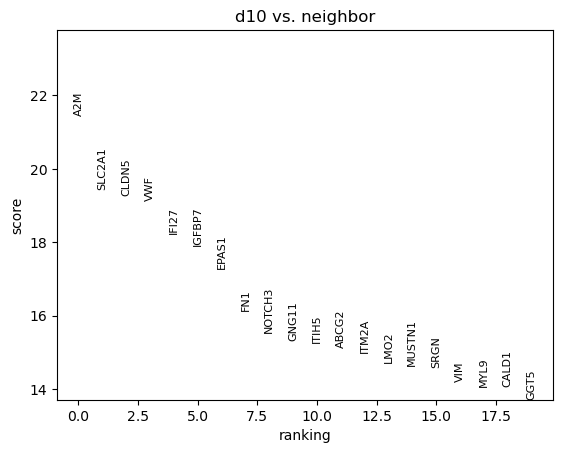

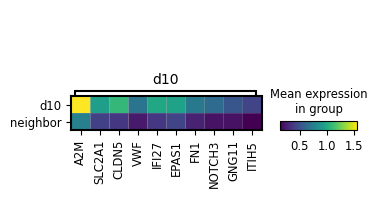

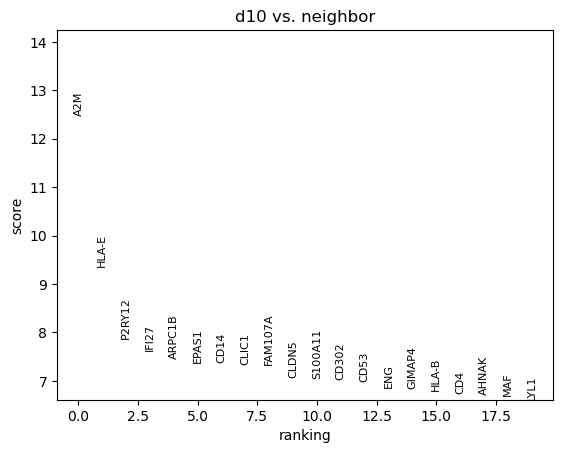

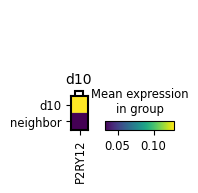

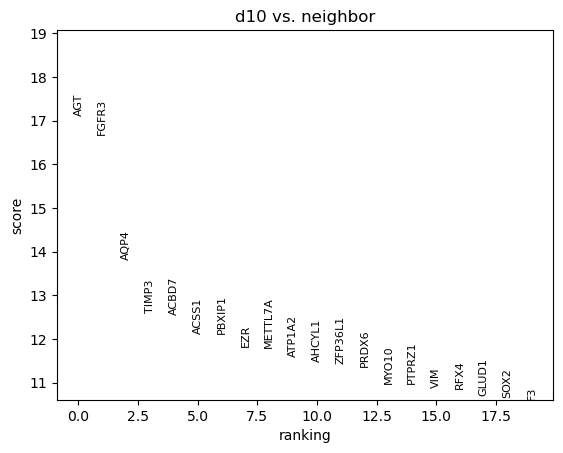

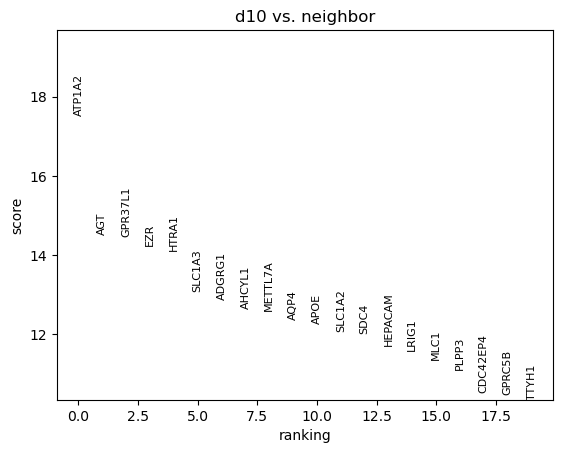

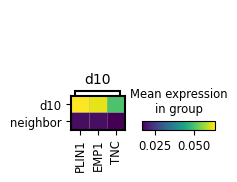

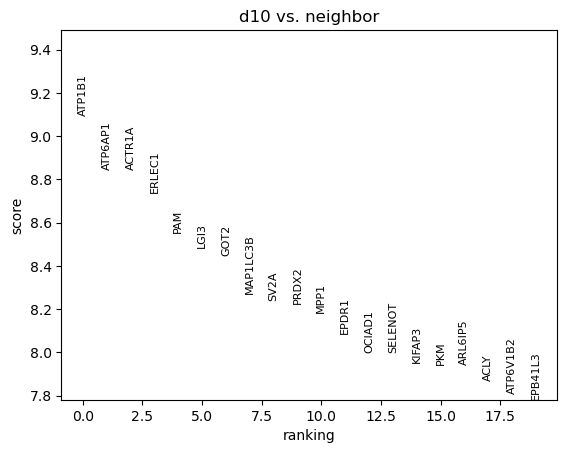

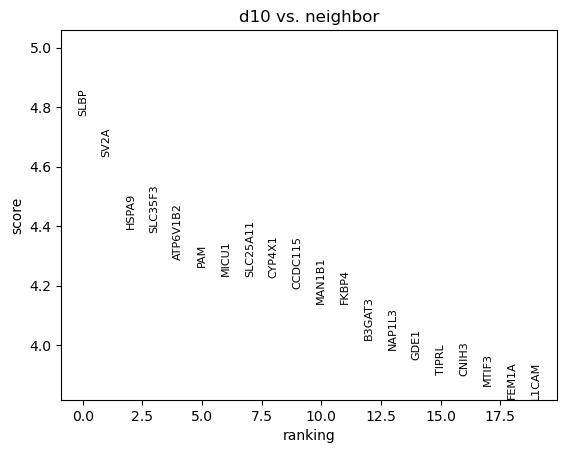

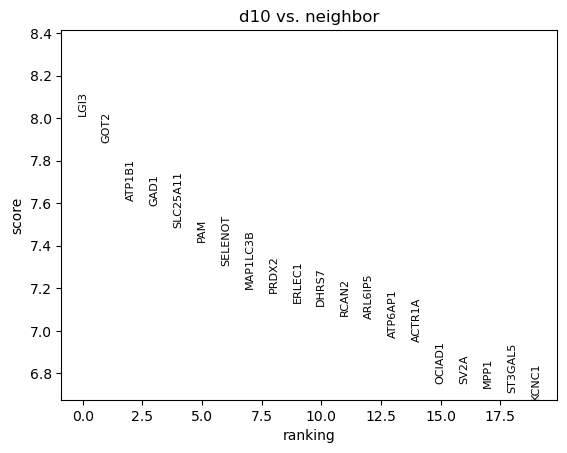

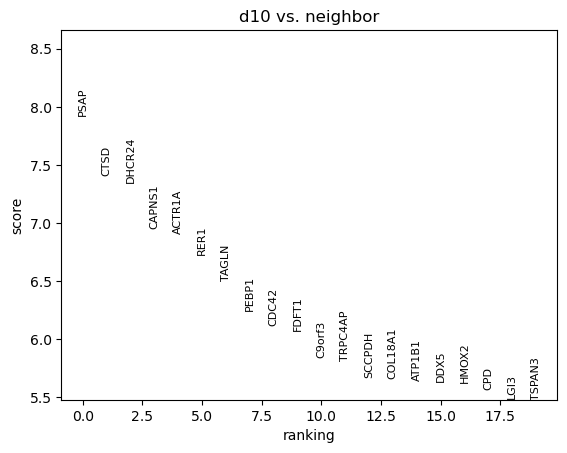

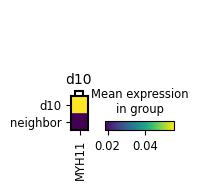

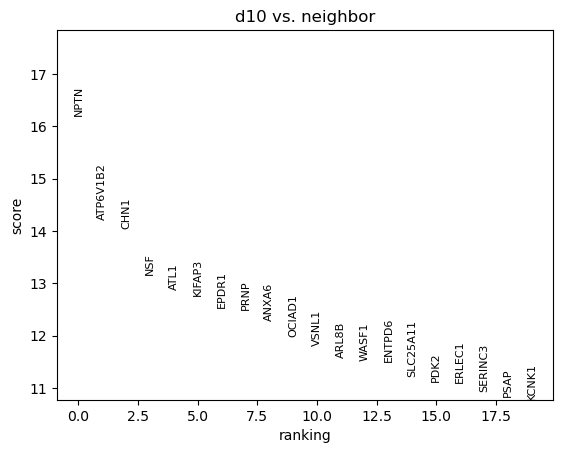

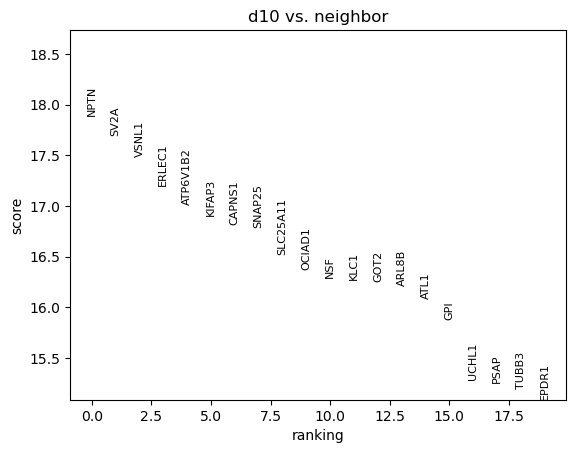

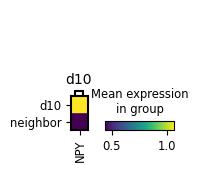

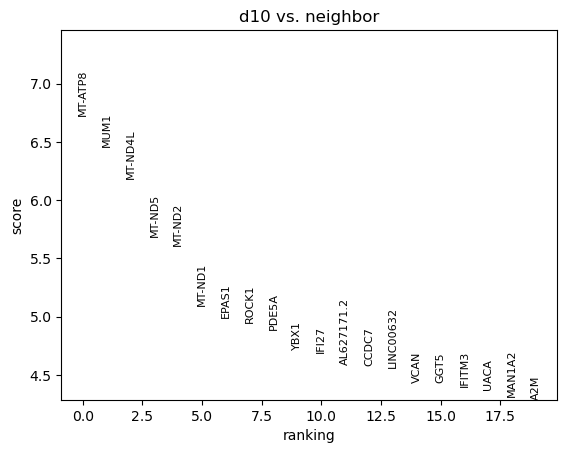

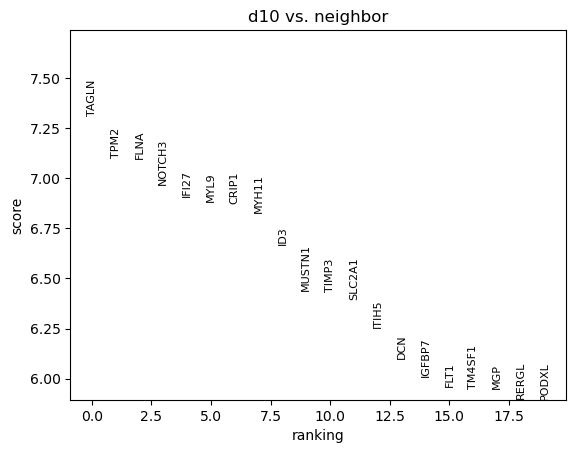

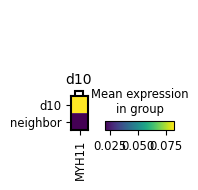

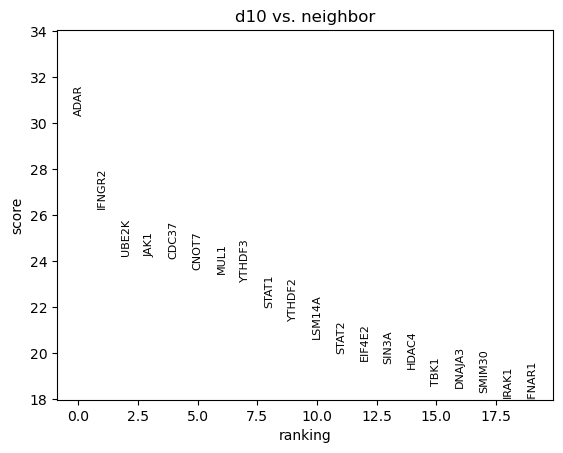

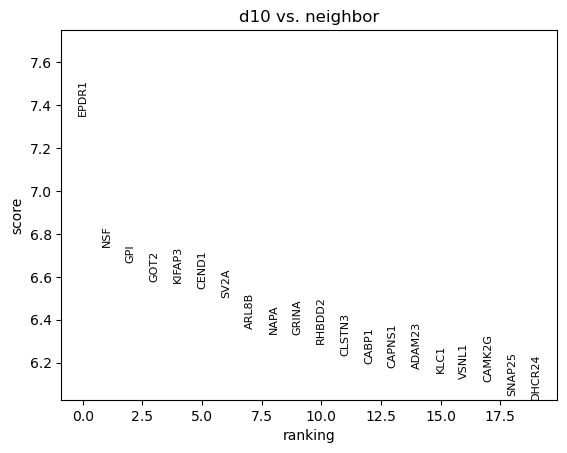

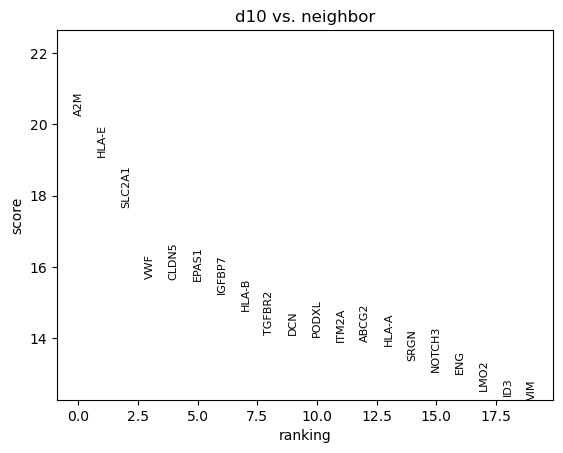

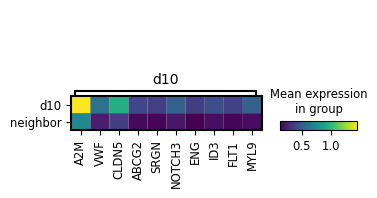

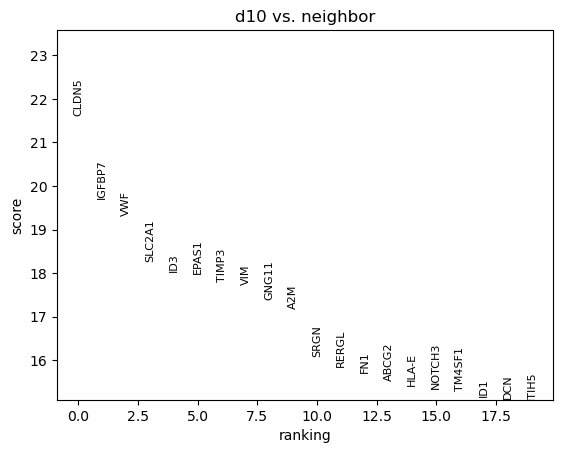

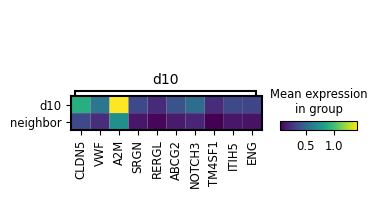

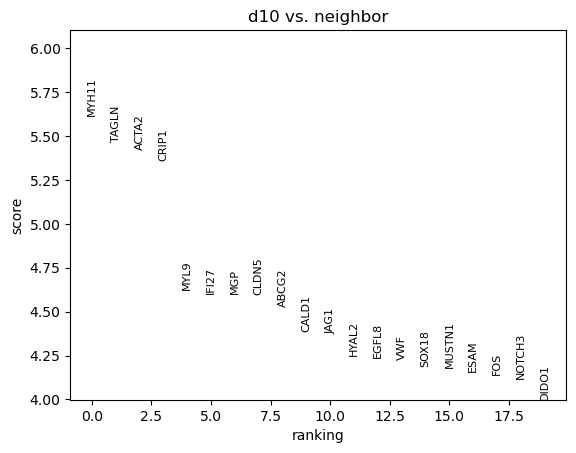

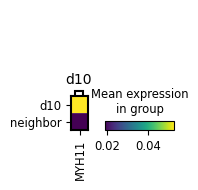

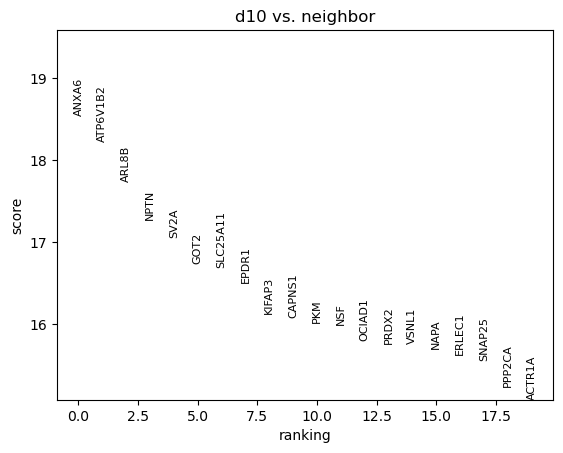

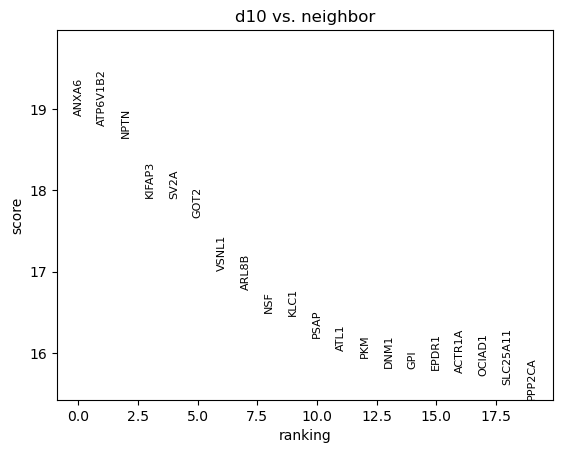

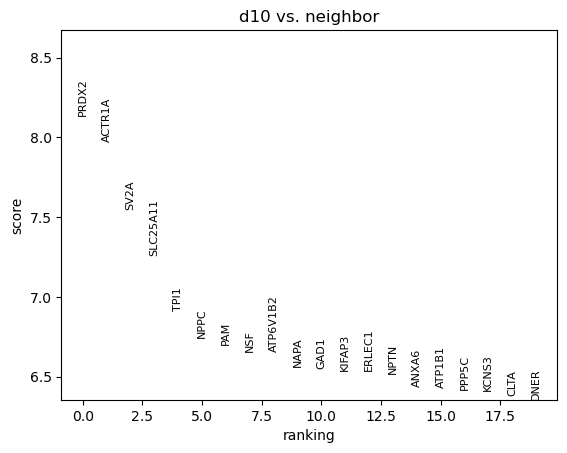

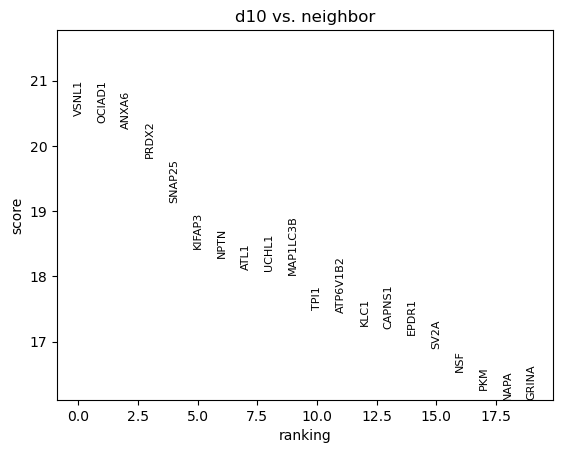

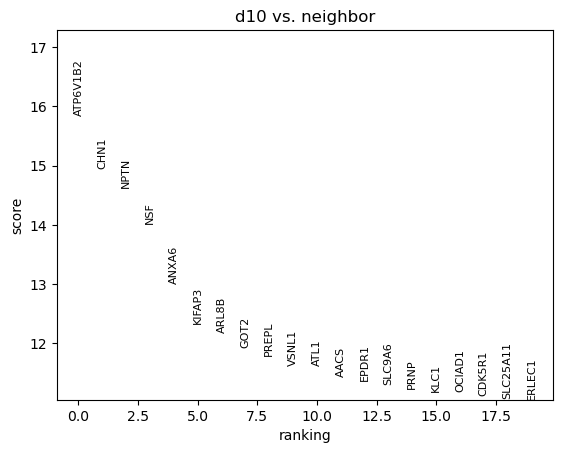

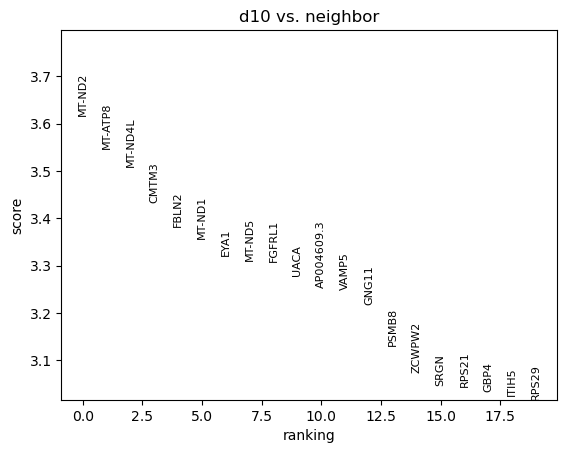

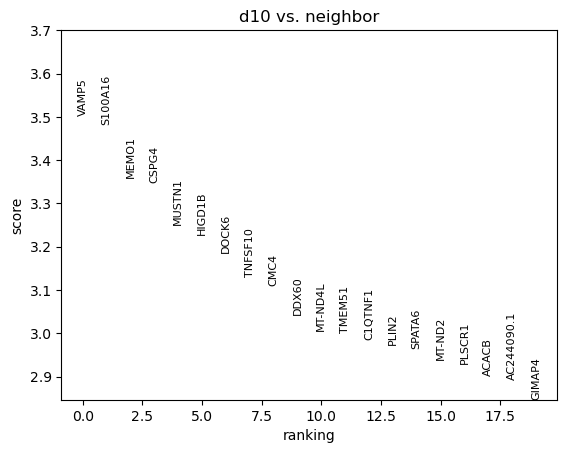

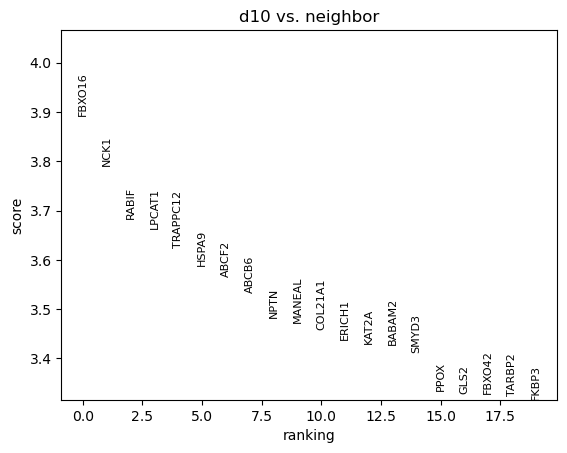

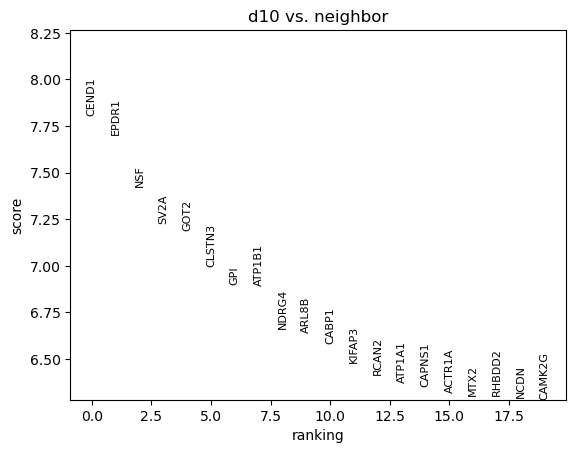

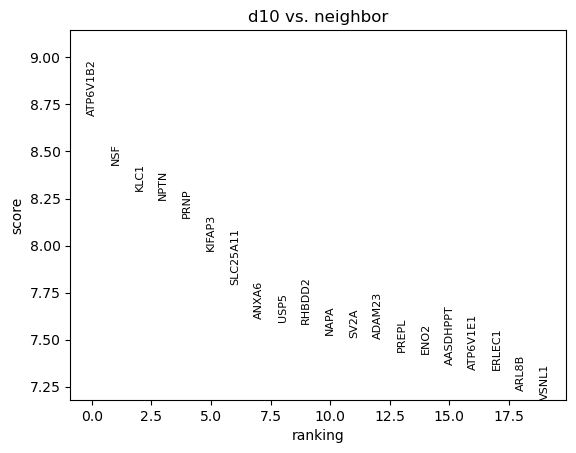

In [38]:
lvl = 'd10'
for sf in sen_flavors:
    member_genes = df_member[sf].dropna().values
    save = os.path.join('plots', 'senmodule_degs', '%s_%s' % (plot_friendly_name(sf), lvl))
    df_deg = senmodule_degenes_neighbors(adata, sf, lvl, batch_col='visarray', save=save, member_genes=member_genes)
    df_deg.to_csv(save+'.csv')